# RL Agent Financial Analysis: Swing Option Trading Performance

**Quantitative Analysis of Deep Reinforcement Learning Agent Performance on Swing Option Exercise Strategies**

This notebook provides comprehensive analysis of the RL agent's performance on monthly swing option contracts, focusing on financial metrics, pricing convergence, and exercise behavior patterns relevant to quantitative trading strategies.

In [14]:
# Configuration: Specify the experiment to analyze
EXPERIMENT_NAME = "MonthlySwing_10"  # Change this to analyze different experiments
print(f"Analyzing experiment: {EXPERIMENT_NAME}")
print(f"Data directory: logs/{EXPERIMENT_NAME}/")

Analyzing experiment: MonthlySwing_10
Data directory: logs/MonthlySwing_10/


In [15]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, glob, warnings
from scipy import stats
import os
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({'figure.figsize': (16, 8), 'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 12, 'xtick.labelsize': 10, 'ytick.labelsize': 10, 'legend.fontsize': 11, 'lines.linewidth': 2.5})
sns.set_palette("husl")

## 1. Data Loading and Preprocessing

In [16]:
# Load data for the specified experiment only
experiment_dir = f'logs/{EXPERIMENT_NAME}'

# Load training logs with episode-level performance metrics
training_file = f'{experiment_dir}/{EXPERIMENT_NAME}_training.csv'
training_data = pd.read_csv(training_file) if os.path.exists(training_file) else pd.DataFrame()

# Load evaluation data with option pricing and confidence intervals
eval_file = f'{experiment_dir}/{EXPERIMENT_NAME}_evaluation.csv'
eval_data = pd.read_csv(eval_file) if os.path.exists(eval_file) else pd.DataFrame()

# Load raw episode data with detailed exercise and inventory information
raw_file = f'{experiment_dir}/{EXPERIMENT_NAME}_raw_episodes.csv'
raw_data = pd.read_csv(raw_file) if os.path.exists(raw_file) else pd.DataFrame()

# Load validation runs data
validation_dir = f'{experiment_dir}/validation_runs'
validation_files = glob.glob(f'{validation_dir}/eval_run_*.csv')
validation_data = {}
for f in validation_files:
    run_num = int(f.split('_')[-1].split('.')[0])
    validation_data[run_num] = pd.read_csv(f)

# Get the last (most recent) validation run
last_validation_run = max(validation_data.keys()) if validation_data else None
last_validation_data = validation_data[last_validation_run] if last_validation_run else pd.DataFrame()

# Calculate financial metrics: Sharpe ratio approximation, return volatility, and drawdown
if not training_data.empty:
    training_data['rolling_return'] = training_data['return'].rolling(100, min_periods=1).mean()
    training_data['return_volatility'] = training_data['return'].rolling(100, min_periods=1).std()
    training_data['sharpe_approx'] = training_data['rolling_return'] / (training_data['return_volatility'] + 1e-8)
    training_data['cumulative_max'] = training_data['rolling_return'].cummax()
    training_data['drawdown'] = training_data['rolling_return'] - training_data['cumulative_max']

print(f"Loaded data for experiment: {EXPERIMENT_NAME}")
print(f"Training episodes: {len(training_data)}")
print(f"Evaluation checkpoints: {len(eval_data)}")
print(f"Raw episodes: {len(raw_data)}")
print(f"Validation runs available: {list(validation_data.keys())}")
print(f"Last validation run: {last_validation_run} with {len(last_validation_data)} steps")

Loaded data for experiment: MonthlySwing_10
Training episodes: 16384
Evaluation checkpoints: 18
Raw episodes: 77824
Validation runs available: [3000, 15000, 1000, 11000, 9000, 5000, 1, 7000, 16384, 13000, 16000, 2000, 14000, 8000, 4000, 10000, 12000, 6000]
Last validation run: 16384 with 176974 steps


## 2. Training Performance Analysis

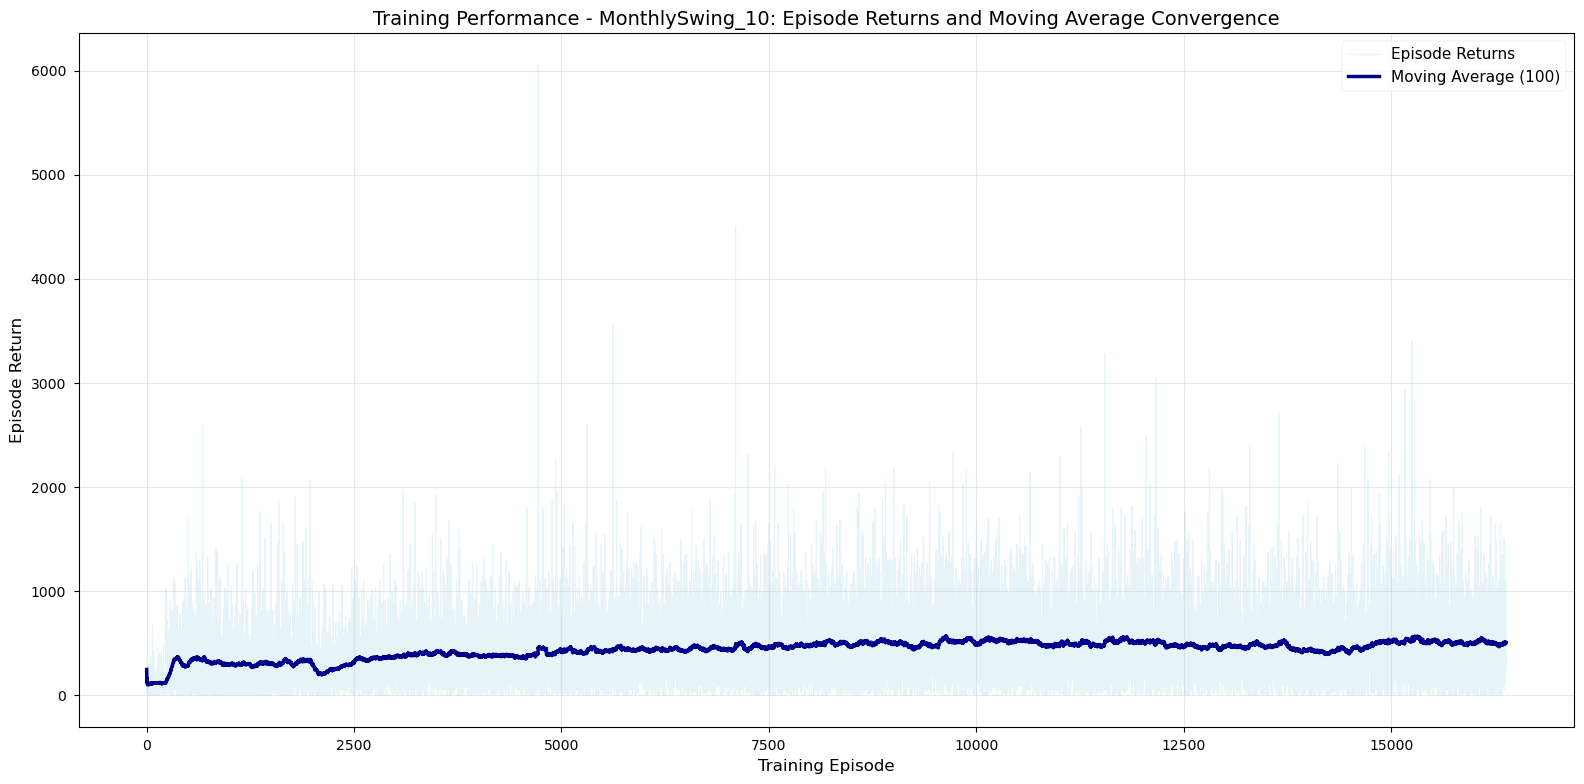

\nFinal Performance Metrics (Last 100 Episodes):
Mean Return: 507.31 ± 347.50
Sharpe Ratio: 1.385 ± 0.053
Maximum Drawdown: -106.77
Return Volatility: 355.81


In [17]:
if not training_data.empty:
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    # Episode returns with moving average
    ax.plot(training_data['episode'], training_data['return'], alpha=0.3, linewidth=0.8, color='lightblue', label='Episode Returns')
    ax.plot(training_data['episode'], training_data['rolling_return'], linewidth=2.5, color='darkblue', label='Moving Average (100)')
    ax.set_xlabel('Training Episode')
    ax.set_ylabel('Episode Return')
    ax.set_title(f'Training Performance - {EXPERIMENT_NAME}: Episode Returns and Moving Average Convergence')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Financial performance summary statistics
    latest_data = training_data.tail(100)  # Last 100 episodes
    print(f"\\nFinal Performance Metrics (Last 100 Episodes):")
    print(f"Mean Return: {latest_data['return'].mean():.2f} ± {latest_data['return'].std():.2f}")
    print(f"Sharpe Ratio: {latest_data['sharpe_approx'].mean():.3f} ± {latest_data['sharpe_approx'].std():.3f}")
    print(f"Maximum Drawdown: {latest_data['drawdown'].min():.2f}")
    print(f"Return Volatility: {latest_data['return_volatility'].mean():.2f}")
else:
    print("No training data available for visualization")

## 3. Option Pricing and Evaluation Analysis

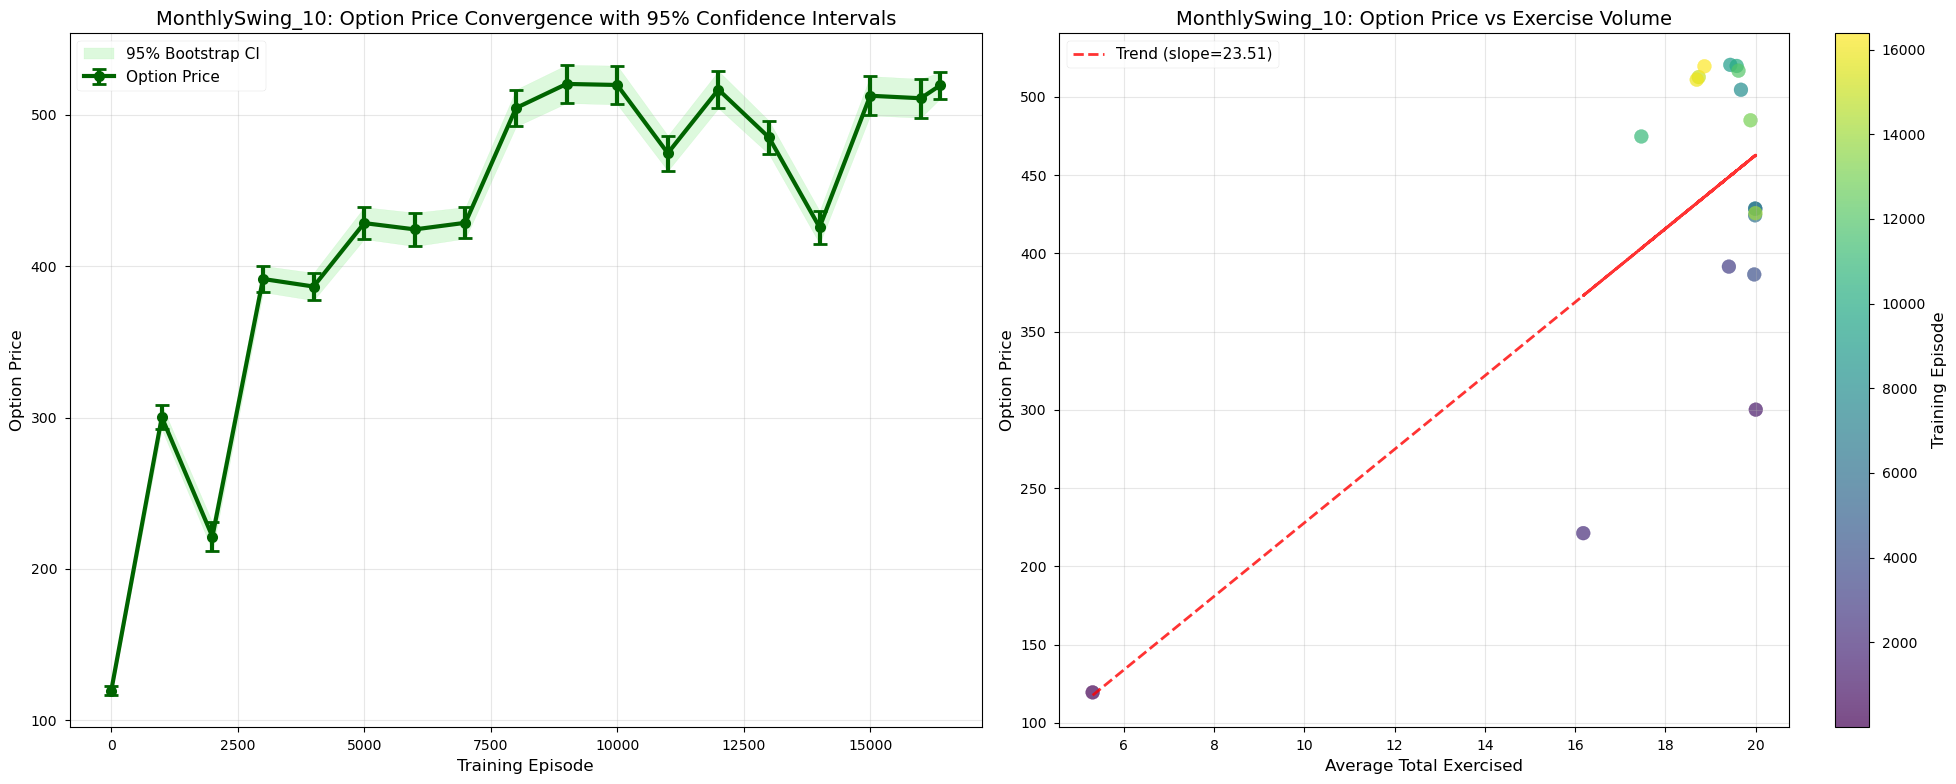

\nOption Pricing Analysis for MonthlySwing_10:
Final Option Price: 519.62 ± 8.76
Price-Exercise Volume Correlation: 0.718
Price Convergence (Std reduction): 102.46 → 404.60
Average Exercise Volume: 18.49
Exercise Count per Period: 14.5


In [18]:
if not eval_data.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Option price evolution with bootstrapped 95% confidence intervals
    ax1.errorbar(eval_data['training_episode'], eval_data['option_price'], 
                yerr=eval_data['confidence_95'], capsize=5, capthick=2, linewidth=3, 
                marker='o', markersize=8, color='darkgreen', label='Option Price')
    ax1.fill_between(eval_data['training_episode'], 
                    eval_data['option_price'] - eval_data['confidence_95'], 
                    eval_data['option_price'] + eval_data['confidence_95'], 
                    alpha=0.3, color='lightgreen', label='95% Bootstrap CI')
    ax1.set_xlabel('Training Episode')
    ax1.set_ylabel('Option Price')
    ax1.set_title(f'{EXPERIMENT_NAME}: Option Price Convergence with 95% Confidence Intervals')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Option price vs exercise volume relationship
    ax2.scatter(eval_data['avg_total_exercised'], eval_data['option_price'], 
               c=eval_data['training_episode'], cmap='viridis', s=100, alpha=0.7)
    # Add trend line
    z = np.polyfit(eval_data['avg_total_exercised'], eval_data['option_price'], 1)
    p = np.poly1d(z)
    ax2.plot(eval_data['avg_total_exercised'], p(eval_data['avg_total_exercised']), 
            "r--", alpha=0.8, linewidth=2, label=f'Trend (slope={z[0]:.2f})')
    ax2.set_xlabel('Average Total Exercised')
    ax2.set_ylabel('Option Price')
    ax2.set_title(f'{EXPERIMENT_NAME}: Option Price vs Exercise Volume')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    cbar = plt.colorbar(ax2.collections[0], ax=ax2)
    cbar.set_label('Training Episode')
    
    plt.tight_layout()
    plt.show()
    
    # Option pricing metrics summary
    correlation = np.corrcoef(eval_data['avg_total_exercised'], eval_data['option_price'])[0,1]
    print(f"\\nOption Pricing Analysis for {EXPERIMENT_NAME}:")
    print(f"Final Option Price: {eval_data['option_price'].iloc[-1]:.2f} ± {eval_data['confidence_95'].iloc[-1]:.2f}")
    print(f"Price-Exercise Volume Correlation: {correlation:.3f}")
    print(f"Price Convergence (Std reduction): {eval_data['price_std'].iloc[0]:.2f} → {eval_data['price_std'].iloc[-1]:.2f}")
    print(f"Average Exercise Volume: {eval_data['avg_total_exercised'].mean():.2f}")
    print(f"Exercise Count per Period: {eval_data['avg_exercise_count'].mean():.1f}")
else:
    print("No evaluation data available for option pricing analysis")

## 4. Episode-Level Return and Exercise Analysis

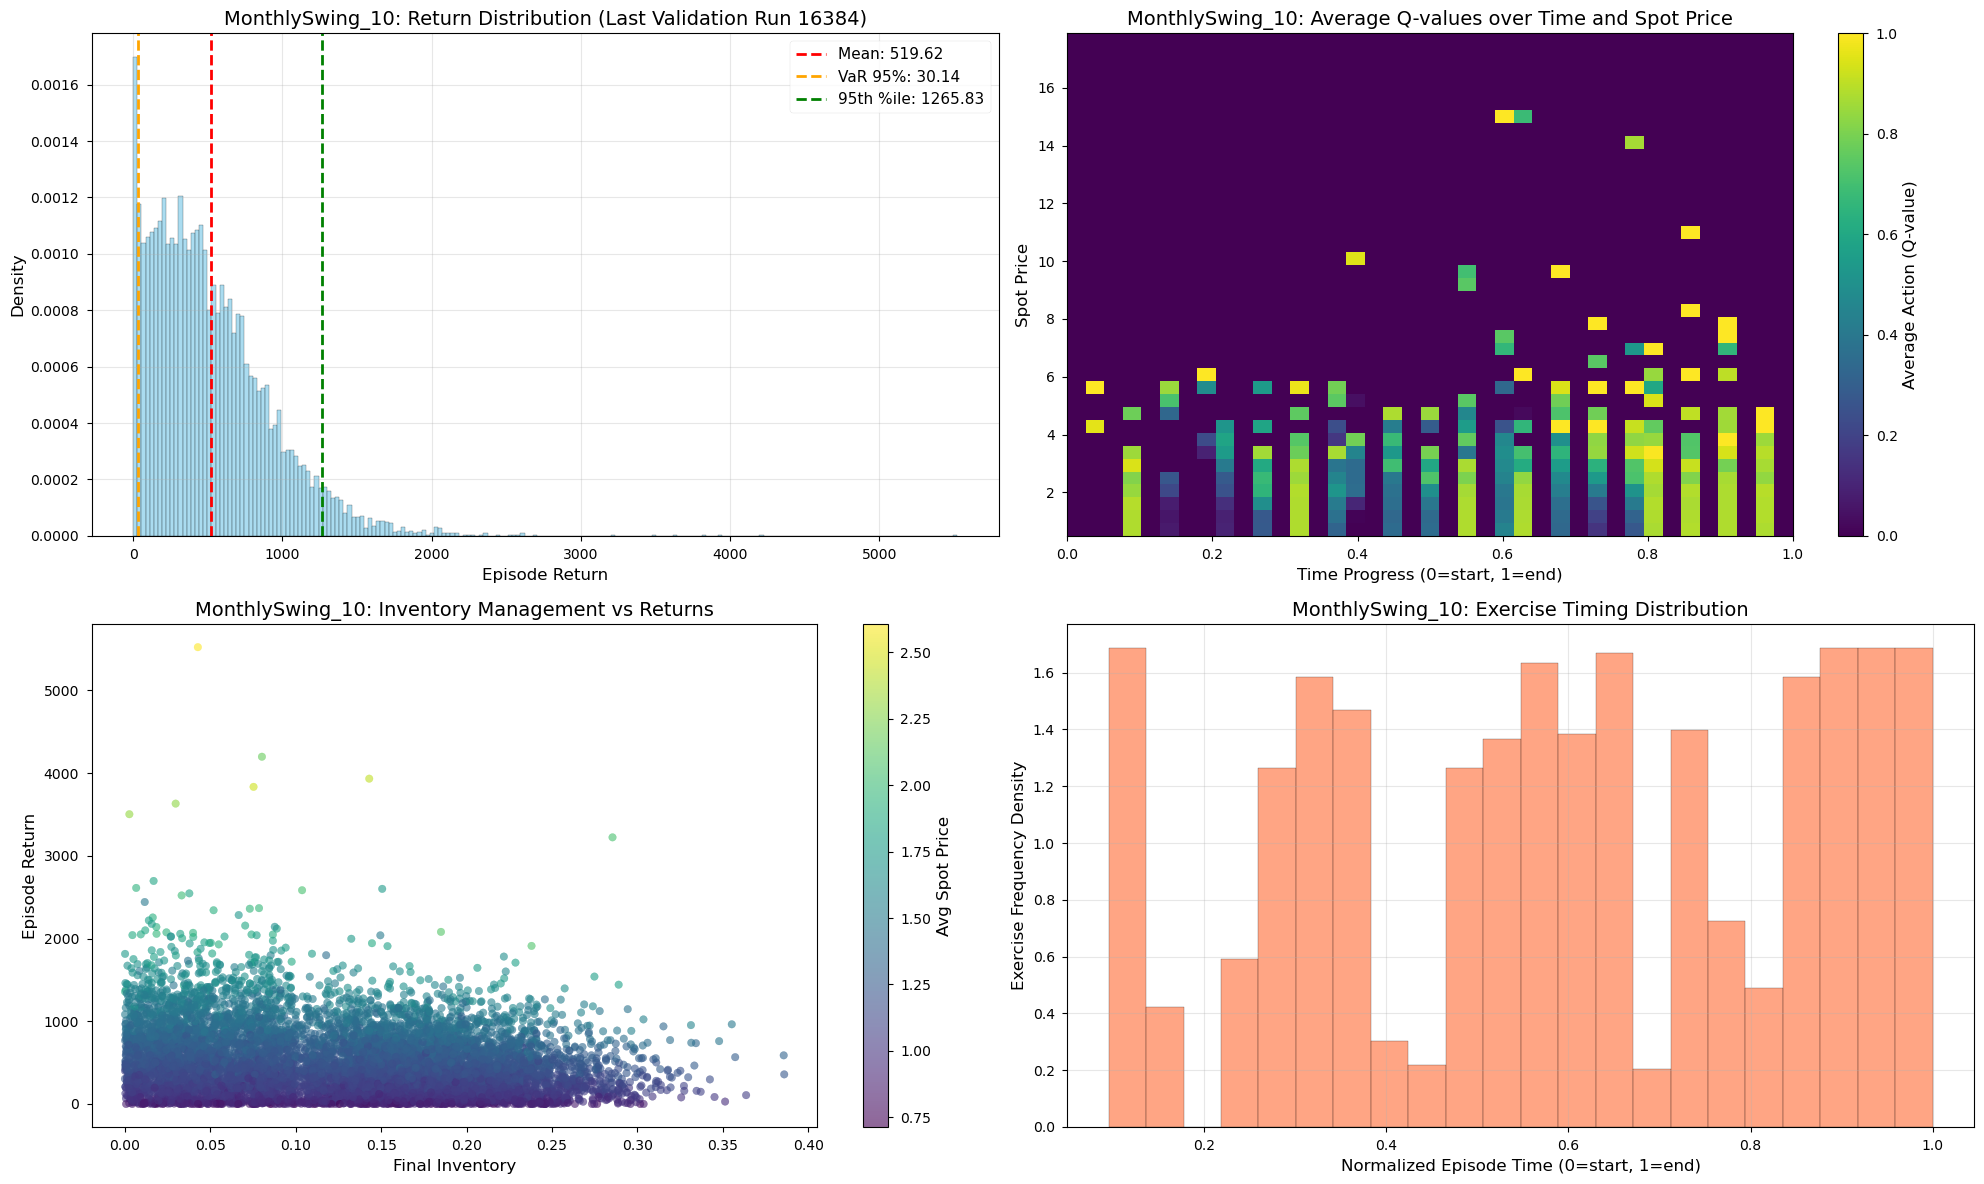

\nValidation Run 16384 Performance Statistics:
Total Episodes Analyzed: 8192
Return Statistics - Mean: 519.62, Std: 404.63, Skew: 1.567
VaR (5%): 30.14, CVaR (5%): 10.61
Exercise Volume - Mean: 18.86, Range: [13.94, 20.00]
Spot Price Exposure - Mean: 1.212, Volatility: 0.183


In [19]:
if not last_validation_data.empty:
    # Calculate episode-level statistics from validation data
    episode_stats = []
    for episode_idx in last_validation_data['episode_idx'].unique():
        episode_data = last_validation_data[last_validation_data['episode_idx'] == episode_idx]
        episode_return = episode_data['reward'].sum()
        total_exercised = episode_data['q_actual'].sum()
        avg_spot = episode_data['spot'].mean()
        final_inventory = episode_data['q_remain'].iloc[-1]
        exercise_count = (episode_data['q_actual'] > 0).sum()
        
        episode_stats.append({
            'episode_idx': episode_idx,
            'return': episode_return,
            'total_exercised': total_exercised,
            'avg_spot_price': avg_spot,
            'final_inventory': final_inventory,
            'exercise_count': exercise_count
        })
    
    validation_episodes = pd.DataFrame(episode_stats)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
    
    # Return distribution analysis with more bins
    returns = validation_episodes['return'].dropna()
    n, bins, patches = ax1.hist(returns, bins=200, alpha=0.7, density=True, color='skyblue', edgecolor='black')
    ax1.axvline(returns.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {returns.mean():.2f}')
    ax1.axvline(returns.quantile(0.05), color='orange', linestyle='--', linewidth=2, label=f'VaR 95%: {returns.quantile(0.05):.2f}')
    ax1.axvline(returns.quantile(0.95), color='green', linestyle='--', linewidth=2, label=f'95th %ile: {returns.quantile(0.95):.2f}')
    ax1.set_xlabel('Episode Return')
    ax1.set_ylabel('Density')
    ax1.set_title(f'{EXPERIMENT_NAME}: Return Distribution (Last Validation Run {last_validation_run})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Average Q-values over time and spot price with double resolution
    time_bins = np.linspace(0, 1, 40)
    spot_bins = np.linspace(last_validation_data['spot'].min(), last_validation_data['spot'].max(), 40)
    
    # Create meshgrid for heatmap
    q_grid = np.zeros((len(time_bins)-1, len(spot_bins)-1))
    for i in range(len(time_bins)-1):
        for j in range(len(spot_bins)-1):
            mask = ((1 - last_validation_data['time_left']) >= time_bins[i]) & \
                   ((1 - last_validation_data['time_left']) < time_bins[i+1]) & \
                   (last_validation_data['spot'] >= spot_bins[j]) & \
                   (last_validation_data['spot'] < spot_bins[j+1])
            if mask.sum() > 0:
                q_grid[i, j] = last_validation_data.loc[mask, 'action'].mean()
    
    im = ax2.imshow(q_grid.T, aspect='auto', origin='lower', cmap='viridis', 
                   extent=[0, 1, spot_bins[0], spot_bins[-1]])
    ax2.set_xlabel('Time Progress (0=start, 1=end)')
    ax2.set_ylabel('Spot Price')
    ax2.set_title(f'{EXPERIMENT_NAME}: Average Q-values over Time and Spot Price')
    plt.colorbar(im, ax=ax2, label='Average Action (Q-value)')
    
    # Final inventory distribution vs returns (same as before)
    scatter = ax3.scatter(validation_episodes['final_inventory'], validation_episodes['return'], 
                         alpha=0.6, c=validation_episodes['avg_spot_price'], cmap='viridis', s=30)
    ax3.set_xlabel('Final Inventory')
    ax3.set_ylabel('Episode Return')
    ax3.set_title(f'{EXPERIMENT_NAME}: Inventory Management vs Returns')
    plt.colorbar(scatter, ax=ax3, label='Avg Spot Price')
    
    # Exercise timing analysis with discrete time steps
    n_time_steps = last_validation_data['step'].max() + 1  # Number of discrete time decisions
    exercise_timing = []
    for episode_idx in last_validation_data['episode_idx'].unique()[:100]:  # Sample first 100 episodes
        episode_data = last_validation_data[last_validation_data['episode_idx'] == episode_idx]
        exercise_steps = episode_data[episode_data['q_actual'] > 0]['step'].values
        if len(exercise_steps) > 0:
            # Normalize by episode length
            episode_length = episode_data['step'].max()
            normalized_timing = exercise_steps / episode_length
            exercise_timing.extend(normalized_timing)
    
    if exercise_timing:
        ax4.hist(exercise_timing, bins=n_time_steps, alpha=0.7, color='coral', edgecolor='black', density=True)
        ax4.set_xlabel('Normalized Episode Time (0=start, 1=end)')
        ax4.set_ylabel('Exercise Frequency Density')
        ax4.set_title(f'{EXPERIMENT_NAME}: Exercise Timing Distribution')
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'No exercise data available', transform=ax4.transAxes, ha='center', va='center', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical summary of validation episode performance
    print(f"\\nValidation Run {last_validation_run} Performance Statistics:")
    print(f"Total Episodes Analyzed: {len(validation_episodes)}")
    print(f"Return Statistics - Mean: {returns.mean():.2f}, Std: {returns.std():.2f}, Skew: {stats.skew(returns):.3f}")
    print(f"VaR (5%): {returns.quantile(0.05):.2f}, CVaR (5%): {returns[returns <= returns.quantile(0.05)].mean():.2f}")
    print(f"Exercise Volume - Mean: {validation_episodes['total_exercised'].mean():.2f}, Range: [{validation_episodes['total_exercised'].min():.2f}, {validation_episodes['total_exercised'].max():.2f}]")
    print(f"Spot Price Exposure - Mean: {validation_episodes['avg_spot_price'].mean():.3f}, Volatility: {validation_episodes['avg_spot_price'].std():.3f}")
else:
    print("No validation data available for detailed analysis")

## 5. Training-Evaluation Convergence Analysis

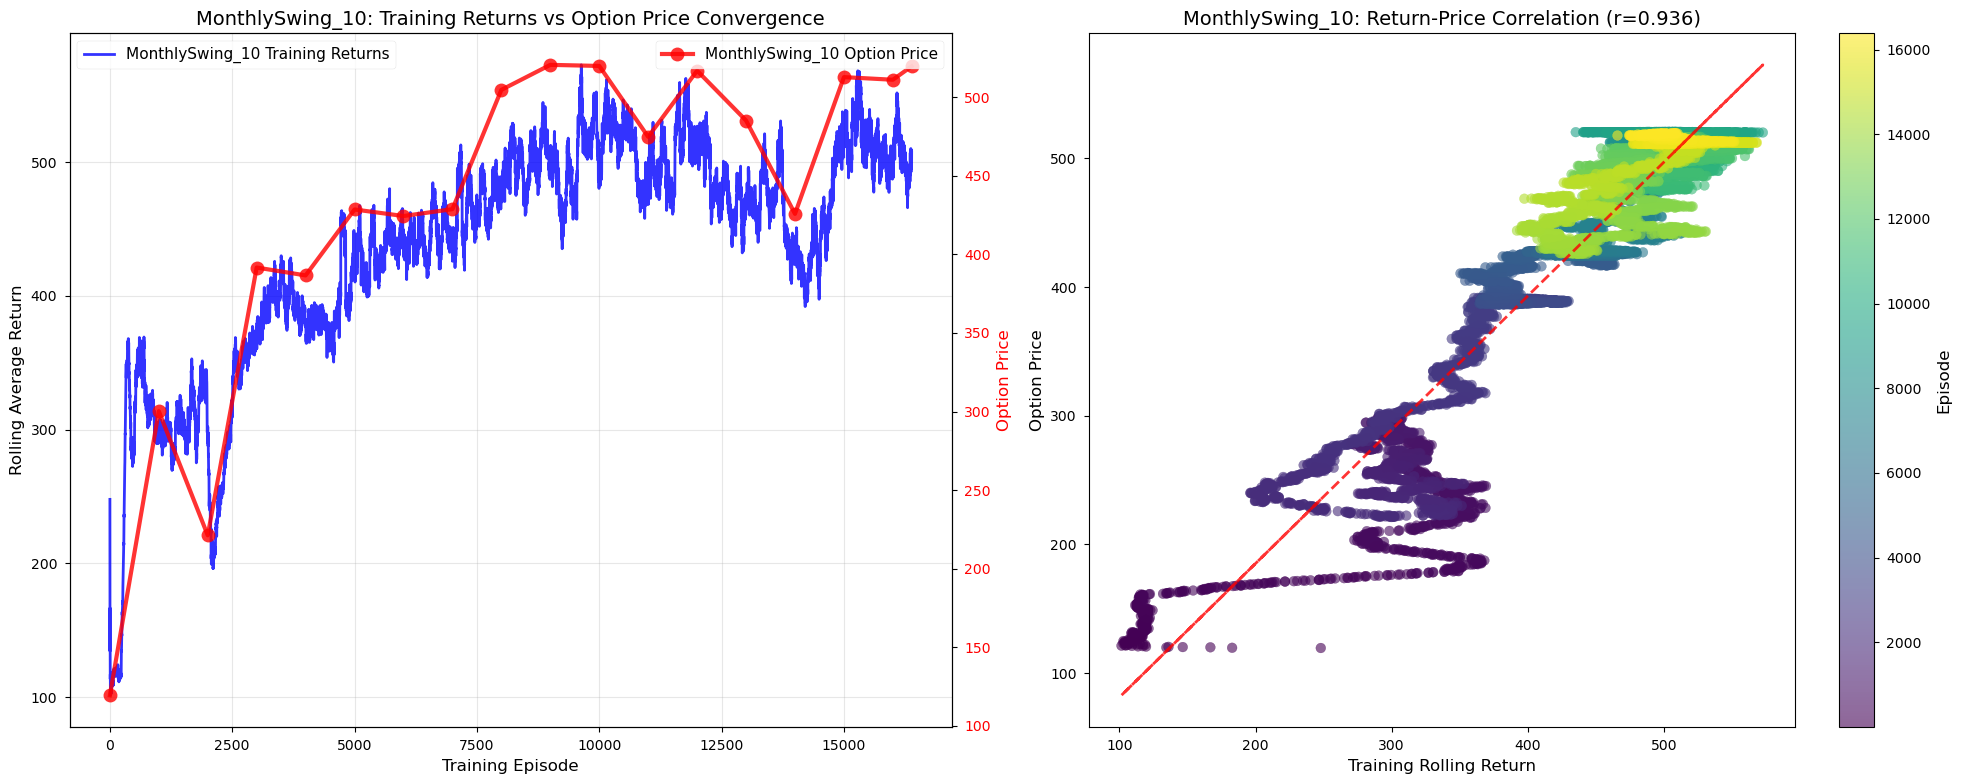

\nConvergence Analysis for MonthlySwing_10:
Early Training Performance (First 100 episodes): 116.49
Late Training Performance (Last 100 episodes): 492.21
Performance Improvement: 322.5%
Option Price Stability (CoV): 0.264


In [20]:
if not training_data.empty and not eval_data.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Overlay training returns with evaluation checkpoints
    ax1.plot(training_data['episode'], training_data['rolling_return'], linewidth=2, alpha=0.8, label=f'{EXPERIMENT_NAME} Training Returns', color='blue')
    
    ax1_twin = ax1.twinx()
    ax1_twin.plot(eval_data['training_episode'], eval_data['option_price'], 'o-', linewidth=3, markersize=10, color='red', alpha=0.8, label=f'{EXPERIMENT_NAME} Option Price')
    ax1_twin.set_ylabel('Option Price', color='red')
    ax1_twin.tick_params(axis='y', labelcolor='red')
    
    ax1.set_xlabel('Training Episode')
    ax1.set_ylabel('Rolling Average Return')
    ax1.set_title(f'{EXPERIMENT_NAME}: Training Returns vs Option Price Convergence')
    ax1.legend(loc='upper left')
    ax1_twin.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Performance correlation analysis
    if not eval_data.empty and len(eval_data) > 1:
        # Interpolate evaluation data to match training episodes
        eval_interp = np.interp(training_data['episode'], eval_data['training_episode'], eval_data['option_price'])
        valid_idx = ~np.isnan(eval_interp) & ~np.isnan(training_data['rolling_return'])
        
        if valid_idx.sum() > 10:  # Ensure sufficient data points
            correlation = np.corrcoef(training_data['rolling_return'][valid_idx], eval_interp[valid_idx])[0,1]
            ax2.scatter(training_data['rolling_return'][valid_idx], eval_interp[valid_idx], alpha=0.6, s=50, c=training_data['episode'][valid_idx], cmap='viridis')
            z = np.polyfit(training_data['rolling_return'][valid_idx], eval_interp[valid_idx], 1)
            p = np.poly1d(z)
            ax2.plot(training_data['rolling_return'][valid_idx], p(training_data['rolling_return'][valid_idx]), "r--", alpha=0.8, linewidth=2)
            ax2.set_xlabel('Training Rolling Return')
            ax2.set_ylabel('Option Price')
            ax2.set_title(f'{EXPERIMENT_NAME}: Return-Price Correlation (r={correlation:.3f})')
            plt.colorbar(ax2.collections[0], ax=ax2, label='Episode')
        else:
            ax2.text(0.5, 0.5, 'Insufficient data for correlation analysis', transform=ax2.transAxes, ha='center', va='center', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # Convergence metrics
    if len(training_data) > 100:
        early_performance = training_data.head(100)['rolling_return'].mean()
        late_performance = training_data.tail(100)['rolling_return'].mean()
        performance_improvement = ((late_performance - early_performance) / abs(early_performance)) * 100
        
        print(f"\\nConvergence Analysis for {EXPERIMENT_NAME}:")
        print(f"Early Training Performance (First 100 episodes): {early_performance:.2f}")
        print(f"Late Training Performance (Last 100 episodes): {late_performance:.2f}")
        print(f"Performance Improvement: {performance_improvement:.1f}%")
        
        if not eval_data.empty and len(eval_data) > 1:
            price_stability = eval_data['option_price'].std() / eval_data['option_price'].mean()
            print(f"Option Price Stability (CoV): {price_stability:.3f}")
elif not training_data.empty:
    print("Evaluation data not available - showing training-only analysis")
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.plot(training_data['episode'], training_data['rolling_return'], linewidth=2, alpha=0.8, label=f'{EXPERIMENT_NAME} Training Returns')
    ax.set_xlabel('Training Episode')
    ax.set_ylabel('Rolling Average Return')
    ax.set_title(f'{EXPERIMENT_NAME}: Training Performance (No Evaluation Data)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()
else:
    print("No data available for convergence analysis")

## 6. Exercise Strategy and Market Conditions Analysis

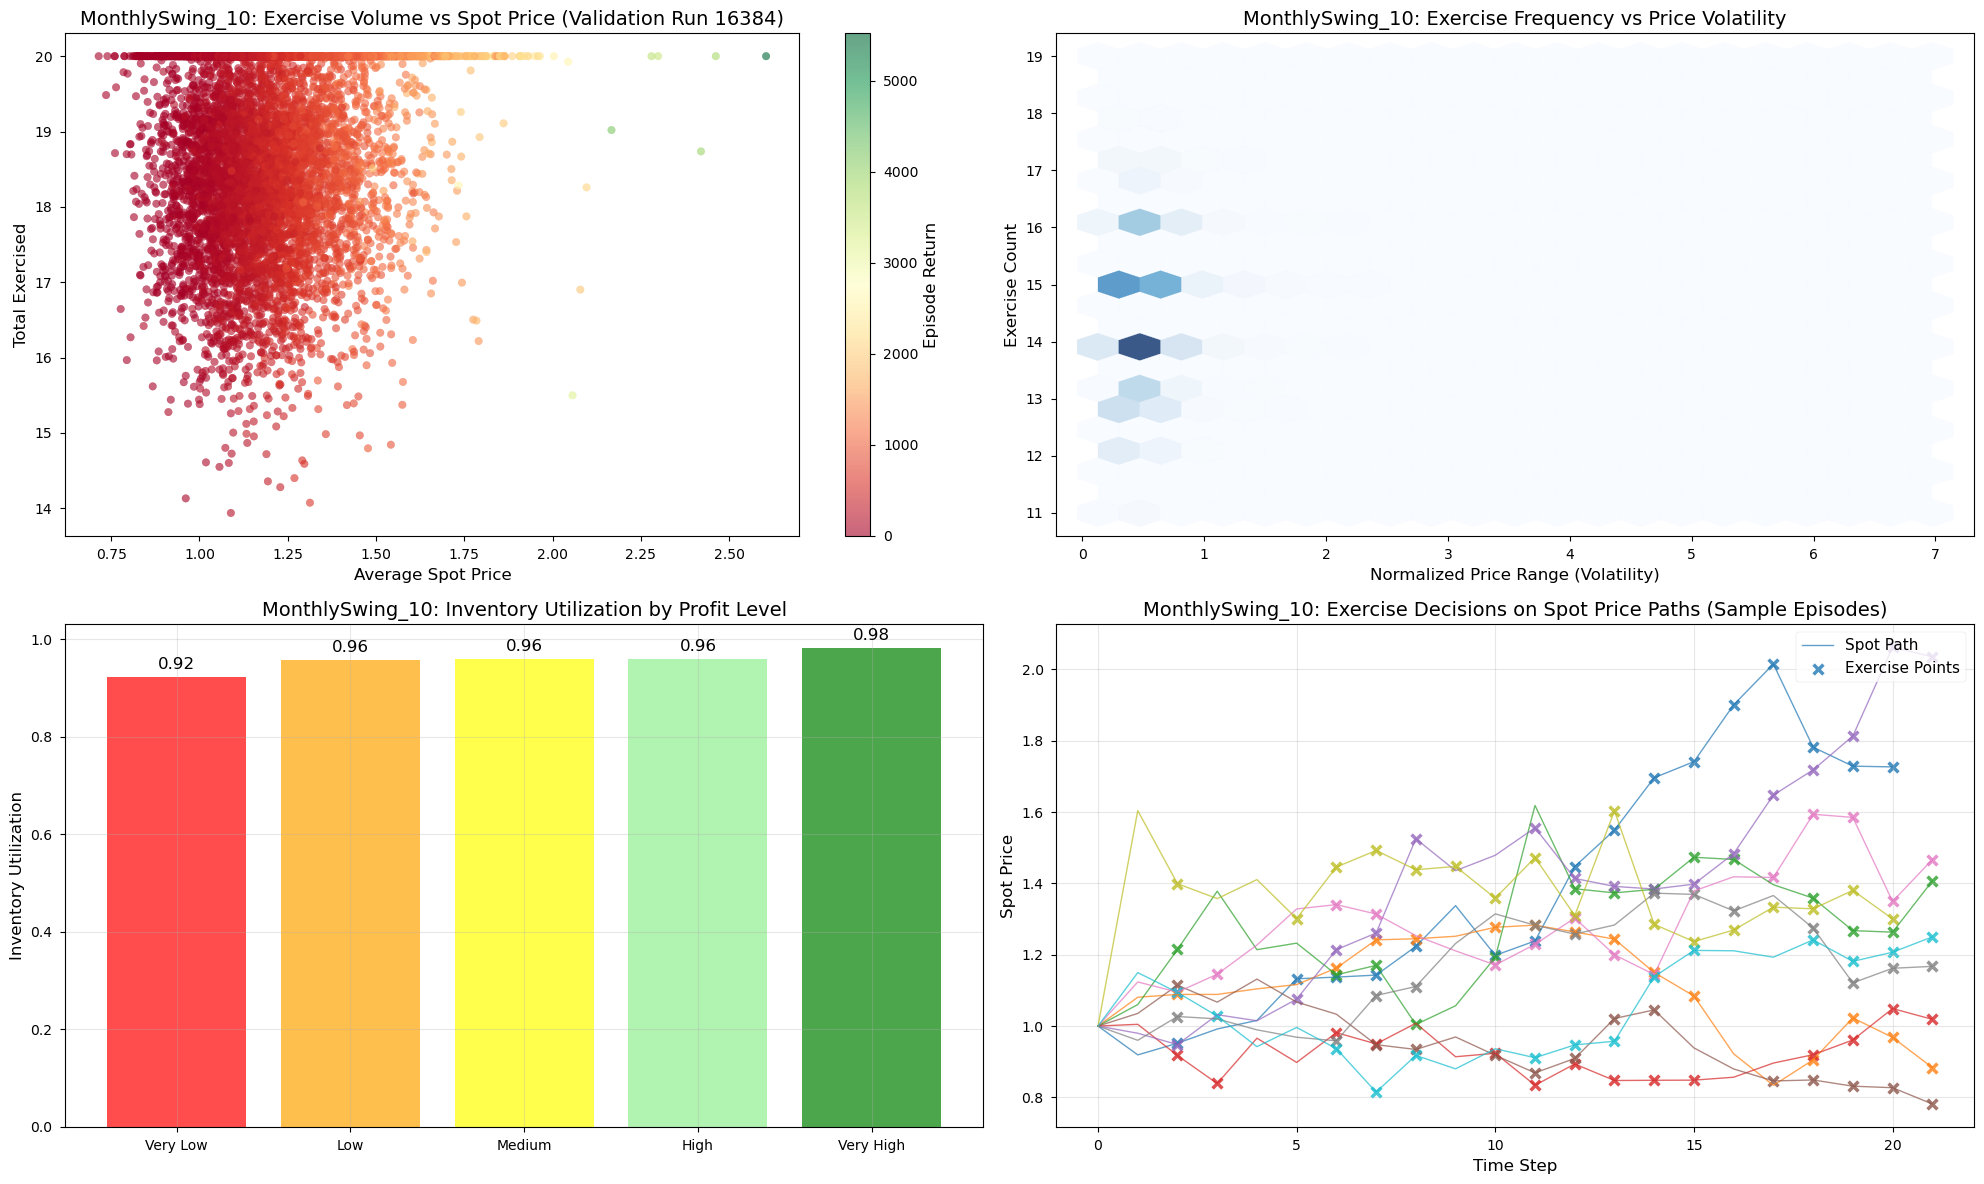

\nExercise Strategy Analysis (Validation Run 16384):
High-Return Episodes (Top 20%):
  - Avg Exercise Count: 14.8
  - Avg Total Exercised: 19.34
  - Avg Spot Price: 1.477
  - Inventory Utilization: 0.949
\nLow-Return Episodes (Bottom 20%):
  - Avg Exercise Count: 14.2
  - Avg Total Exercised: 18.62
  - Avg Spot Price: 0.987
  - Inventory Utilization: 0.914
\nReturn Correlations (Validation Run 16384):
  - total_exercised: 0.229
  - exercise_count: 0.173
  - avg_spot_price: 0.959
  - price_volatility: 0.686
  - final_inventory: -0.242


In [21]:
if not last_validation_data.empty:
    # Use the validation_episodes data from the previous cell
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
    
    # Exercise decisions vs spot price conditions
    validation_episodes['price_volatility'] = last_validation_data.groupby('episode_idx')['spot'].apply(lambda x: x.max() - x.min()).values
    validation_episodes['price_range_norm'] = validation_episodes['price_volatility'] / validation_episodes['avg_spot_price']
    
    scatter1 = ax1.scatter(validation_episodes['avg_spot_price'], validation_episodes['total_exercised'], 
                          c=validation_episodes['return'], cmap='RdYlGn', alpha=0.6, s=30)
    ax1.set_xlabel('Average Spot Price')
    ax1.set_ylabel('Total Exercised')
    ax1.set_title(f'{EXPERIMENT_NAME}: Exercise Volume vs Spot Price (Validation Run {last_validation_run})')
    plt.colorbar(scatter1, ax=ax1, label='Episode Return')
    
    # Exercise timing relative to price volatility
    ax2.hexbin(validation_episodes['price_range_norm'], validation_episodes['exercise_count'], 
              gridsize=20, cmap='Blues', alpha=0.8)
    ax2.set_xlabel('Normalized Price Range (Volatility)')
    ax2.set_ylabel('Exercise Count')
    ax2.set_title(f'{EXPERIMENT_NAME}: Exercise Frequency vs Price Volatility')
    
    # Inventory management effectiveness
    max_inventory = validation_episodes['final_inventory'].max() + validation_episodes['total_exercised'].max()
    validation_episodes['inventory_utilization'] = validation_episodes['total_exercised'] / max_inventory
    profit_bins = pd.cut(validation_episodes['return'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    inventory_by_profit = validation_episodes.groupby(profit_bins)['inventory_utilization'].mean()
    
    bars = ax3.bar(range(len(inventory_by_profit)), inventory_by_profit.values, 
                  color=['red', 'orange', 'yellow', 'lightgreen', 'green'], alpha=0.7)
    ax3.set_xticks(range(len(inventory_by_profit)))
    ax3.set_xticklabels(inventory_by_profit.index)
    ax3.set_ylabel('Inventory Utilization')
    ax3.set_title(f'{EXPERIMENT_NAME}: Inventory Utilization by Profit Level')
    ax3.grid(True, alpha=0.3)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.2f}', 
                ha='center', va='bottom')
    
    # Spot price path analysis - exercise decisions along price trajectories
    sample_episodes = last_validation_data['episode_idx'].unique()[:10]  # Sample 10 episodes
    colors = plt.cm.tab10(np.linspace(0, 1, len(sample_episodes)))
    
    for i, episode_idx in enumerate(sample_episodes):
        episode_data = last_validation_data[last_validation_data['episode_idx'] == episode_idx]
        # Plot spot price path
        ax4.plot(episode_data['step'], episode_data['spot'], alpha=0.7, color=colors[i], linewidth=1)
        # Mark exercise points
        exercise_points = episode_data[episode_data['q_actual'] > 0]
        if not exercise_points.empty:
            ax4.scatter(exercise_points['step'], exercise_points['spot'], 
                       color=colors[i], s=50, alpha=0.8, marker='x')
    
    ax4.set_xlabel('Time Step')
    ax4.set_ylabel('Spot Price')
    ax4.set_title(f'{EXPERIMENT_NAME}: Exercise Decisions on Spot Price Paths (Sample Episodes)')
    ax4.grid(True, alpha=0.3)
    ax4.legend(['Spot Path', 'Exercise Points'], loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Strategy effectiveness summary for validation run
    high_return_episodes = validation_episodes[validation_episodes['return'] > validation_episodes['return'].quantile(0.8)]
    low_return_episodes = validation_episodes[validation_episodes['return'] < validation_episodes['return'].quantile(0.2)]
    
    print(f"\\nExercise Strategy Analysis (Validation Run {last_validation_run}):")
    print(f"High-Return Episodes (Top 20%):")
    print(f"  - Avg Exercise Count: {high_return_episodes['exercise_count'].mean():.1f}")
    print(f"  - Avg Total Exercised: {high_return_episodes['total_exercised'].mean():.2f}")
    print(f"  - Avg Spot Price: {high_return_episodes['avg_spot_price'].mean():.3f}")
    print(f"  - Inventory Utilization: {high_return_episodes['inventory_utilization'].mean():.3f}")
    
    print(f"\\nLow-Return Episodes (Bottom 20%):")
    print(f"  - Avg Exercise Count: {low_return_episodes['exercise_count'].mean():.1f}")
    print(f"  - Avg Total Exercised: {low_return_episodes['total_exercised'].mean():.2f}")
    print(f"  - Avg Spot Price: {low_return_episodes['avg_spot_price'].mean():.3f}")
    print(f"  - Inventory Utilization: {low_return_episodes['inventory_utilization'].mean():.3f}")
    
    # Correlation analysis
    correlations = validation_episodes[['return', 'total_exercised', 'exercise_count', 'avg_spot_price', 'price_volatility', 'final_inventory']].corr()['return'].drop('return')
    print(f"\\nReturn Correlations (Validation Run {last_validation_run}):")
    for var, corr in correlations.items():
        print(f"  - {var}: {corr:.3f}")
else:
    print("No validation data available for exercise strategy analysis")

## 7. Summary and Key Financial Insights

In [22]:
# Comprehensive Financial Performance Summary for Specific Experiment
print("="*80)
print(f"RL AGENT SWING OPTION TRADING - FINANCIAL PERFORMANCE SUMMARY")
print(f"EXPERIMENT: {EXPERIMENT_NAME}")
print("="*80)

if not training_data.empty:
    total_episodes = len(training_data)
    final_performance = training_data['return'].tail(100).mean() if len(training_data) >= 100 else training_data['return'].mean()
    performance_volatility = training_data['return'].tail(100).std() if len(training_data) >= 100 else training_data['return'].std()
    max_drawdown = training_data['drawdown'].min() if 'drawdown' in training_data.columns else 'N/A'
    
    print(f"\\n📊 TRAINING PERFORMANCE METRICS:")
    print(f"   • Total Training Episodes: {total_episodes:,}")
    print(f"   • Final Average Return: {final_performance:.2f}")
    print(f"   • Return Volatility: {performance_volatility:.2f}")
    print(f"   • Risk-Adjusted Return (Sharpe): {final_performance/performance_volatility:.3f}")
    print(f"   • Maximum Drawdown: {max_drawdown}")

if not eval_data.empty:
    final_option_price = eval_data['option_price'].iloc[-1]
    price_confidence = eval_data['confidence_95'].iloc[-1]
    avg_exercise_volume = eval_data['avg_total_exercised'].mean()
    
    print(f"\\n💰 OPTION PRICING METRICS:")
    print(f"   • Final Option Price: {final_option_price:.2f} ± {price_confidence:.2f}")
    print(f"   • Price Discovery Efficiency: {(1 - eval_data['price_std'].iloc[-1]/eval_data['price_std'].iloc[0])*100:.1f}% improvement")
    print(f"   • Average Exercise Volume: {avg_exercise_volume:.2f}")

# Validation run analysis
if validation_data and last_validation_data is not None and not last_validation_data.empty:
    validation_episodes = []
    for episode_idx in last_validation_data['episode_idx'].unique():
        episode_data = last_validation_data[last_validation_data['episode_idx'] == episode_idx]
        validation_episodes.append(episode_data['reward'].sum())
    
    val_returns = np.array(validation_episodes)
    profitability_rate = (val_returns > 0).mean() * 100
    val_sharpe = val_returns.mean() / val_returns.std() if val_returns.std() > 0 else 0
    
    print(f"\\n🎯 VALIDATION PERFORMANCE (Run {last_validation_run}):")
    print(f"   • Total Validation Episodes: {len(validation_episodes)}")
    print(f"   • Profitability Rate: {profitability_rate:.1f}%")
    print(f"   • Validation Sharpe Ratio: {val_sharpe:.3f}")
    print(f"   • Mean Validation Return: {val_returns.mean():.2f}")

# Risk management assessment
if validation_data and len(validation_episodes) > 0:
    var_95 = np.percentile(val_returns, 5)
    cvar_95 = val_returns[val_returns <= var_95].mean() if (val_returns <= var_95).sum() > 0 else var_95
    tail_ratio = abs(cvar_95 / val_returns.mean()) if val_returns.mean() != 0 else float('inf')
    
    print(f"\\n⚠️  RISK MANAGEMENT METRICS:")
    print(f"   • Value at Risk (95%): {var_95:.2f}")
    print(f"   • Conditional VaR (95%): {cvar_95:.2f}")
    print(f"   • Tail Risk Ratio: {tail_ratio:.2f}")
    print(f"   • Risk Assessment: {'HIGH RISK' if tail_ratio > 3 else 'MODERATE RISK' if tail_ratio > 1.5 else 'LOW RISK'}")

# Learning progression
if validation_data and len(validation_data) > 1:
    first_run = min(validation_data.keys())
    last_run = max(validation_data.keys())
    
    first_performance = np.mean([validation_data[first_run][validation_data[first_run]['episode_idx'] == ep]['reward'].sum() 
                               for ep in validation_data[first_run]['episode_idx'].unique()[:100]])
    last_performance = np.mean([validation_data[last_run][validation_data[last_run]['episode_idx'] == ep]['reward'].sum() 
                              for ep in validation_data[last_run]['episode_idx'].unique()[:100]])
    
    improvement = ((last_performance - first_performance) / abs(first_performance)) * 100 if first_performance != 0 else 0
    
    print(f"\\n📈 LEARNING PROGRESSION:")
    print(f"   • Early Performance (Run {first_run}): {first_performance:.2f}")
    print(f"   • Latest Performance (Run {last_run}): {last_performance:.2f}")
    print(f"   • Performance Improvement: {improvement:.1f}%")

print(f"\\n🎯 EXPERIMENT-SPECIFIC RECOMMENDATIONS:")
if not training_data.empty and validation_data:
    if final_performance > 100 and profitability_rate > 60:
        print("   ✅ Strong performance - Consider production deployment")
    elif final_performance > 50 and profitability_rate > 50:
        print("   ⚠️  Moderate performance - Additional validation recommended")
    else:
        print("   ❌ Weak performance - Strategy requires further development")
        
    if len(validation_data) >= 5:
        print("   ✅ Sufficient validation data for robust analysis")
    else:
        print("   ⚠️  Limited validation runs - Consider more frequent evaluation")

print(f"\\n📁 DATA AVAILABILITY:")
print(f"   • Training Data: {'✅ Available' if not training_data.empty else '❌ Missing'}")
print(f"   • Evaluation Data: {'✅ Available' if not eval_data.empty else '❌ Missing'}")
print(f"   • Raw Episodes: {'✅ Available' if not raw_data.empty else '❌ Missing'}")
print(f"   • Validation Runs: {len(validation_data)} runs available")

print("\\n" + "="*80)

RL AGENT SWING OPTION TRADING - FINANCIAL PERFORMANCE SUMMARY
EXPERIMENT: MonthlySwing_10
\n📊 TRAINING PERFORMANCE METRICS:
   • Total Training Episodes: 16,384
   • Final Average Return: 507.31
   • Return Volatility: 347.50
   • Risk-Adjusted Return (Sharpe): 1.460
   • Maximum Drawdown: -180.61650618000004
\n💰 OPTION PRICING METRICS:
   • Final Option Price: 519.62 ± 8.76
   • Price Discovery Efficiency: -294.9% improvement
   • Average Exercise Volume: 18.49
\n🎯 VALIDATION PERFORMANCE (Run 16384):
   • Total Validation Episodes: 8192
   • Profitability Rate: 98.8%
   • Validation Sharpe Ratio: 1.284
   • Mean Validation Return: 519.62
\n⚠️  RISK MANAGEMENT METRICS:
   • Value at Risk (95%): 30.14
   • Conditional VaR (95%): 10.61
   • Tail Risk Ratio: 0.02
   • Risk Assessment: LOW RISK
\n📈 LEARNING PROGRESSION:
   • Early Performance (Run 1): 112.26
   • Latest Performance (Run 16384): 521.39
   • Performance Improvement: 364.4%
\n🎯 EXPERIMENT-SPECIFIC RECOMMENDATIONS:
   ✅ Strong

## 8. Advanced Validation Analysis: Action Value Functions and Learning Dynamics

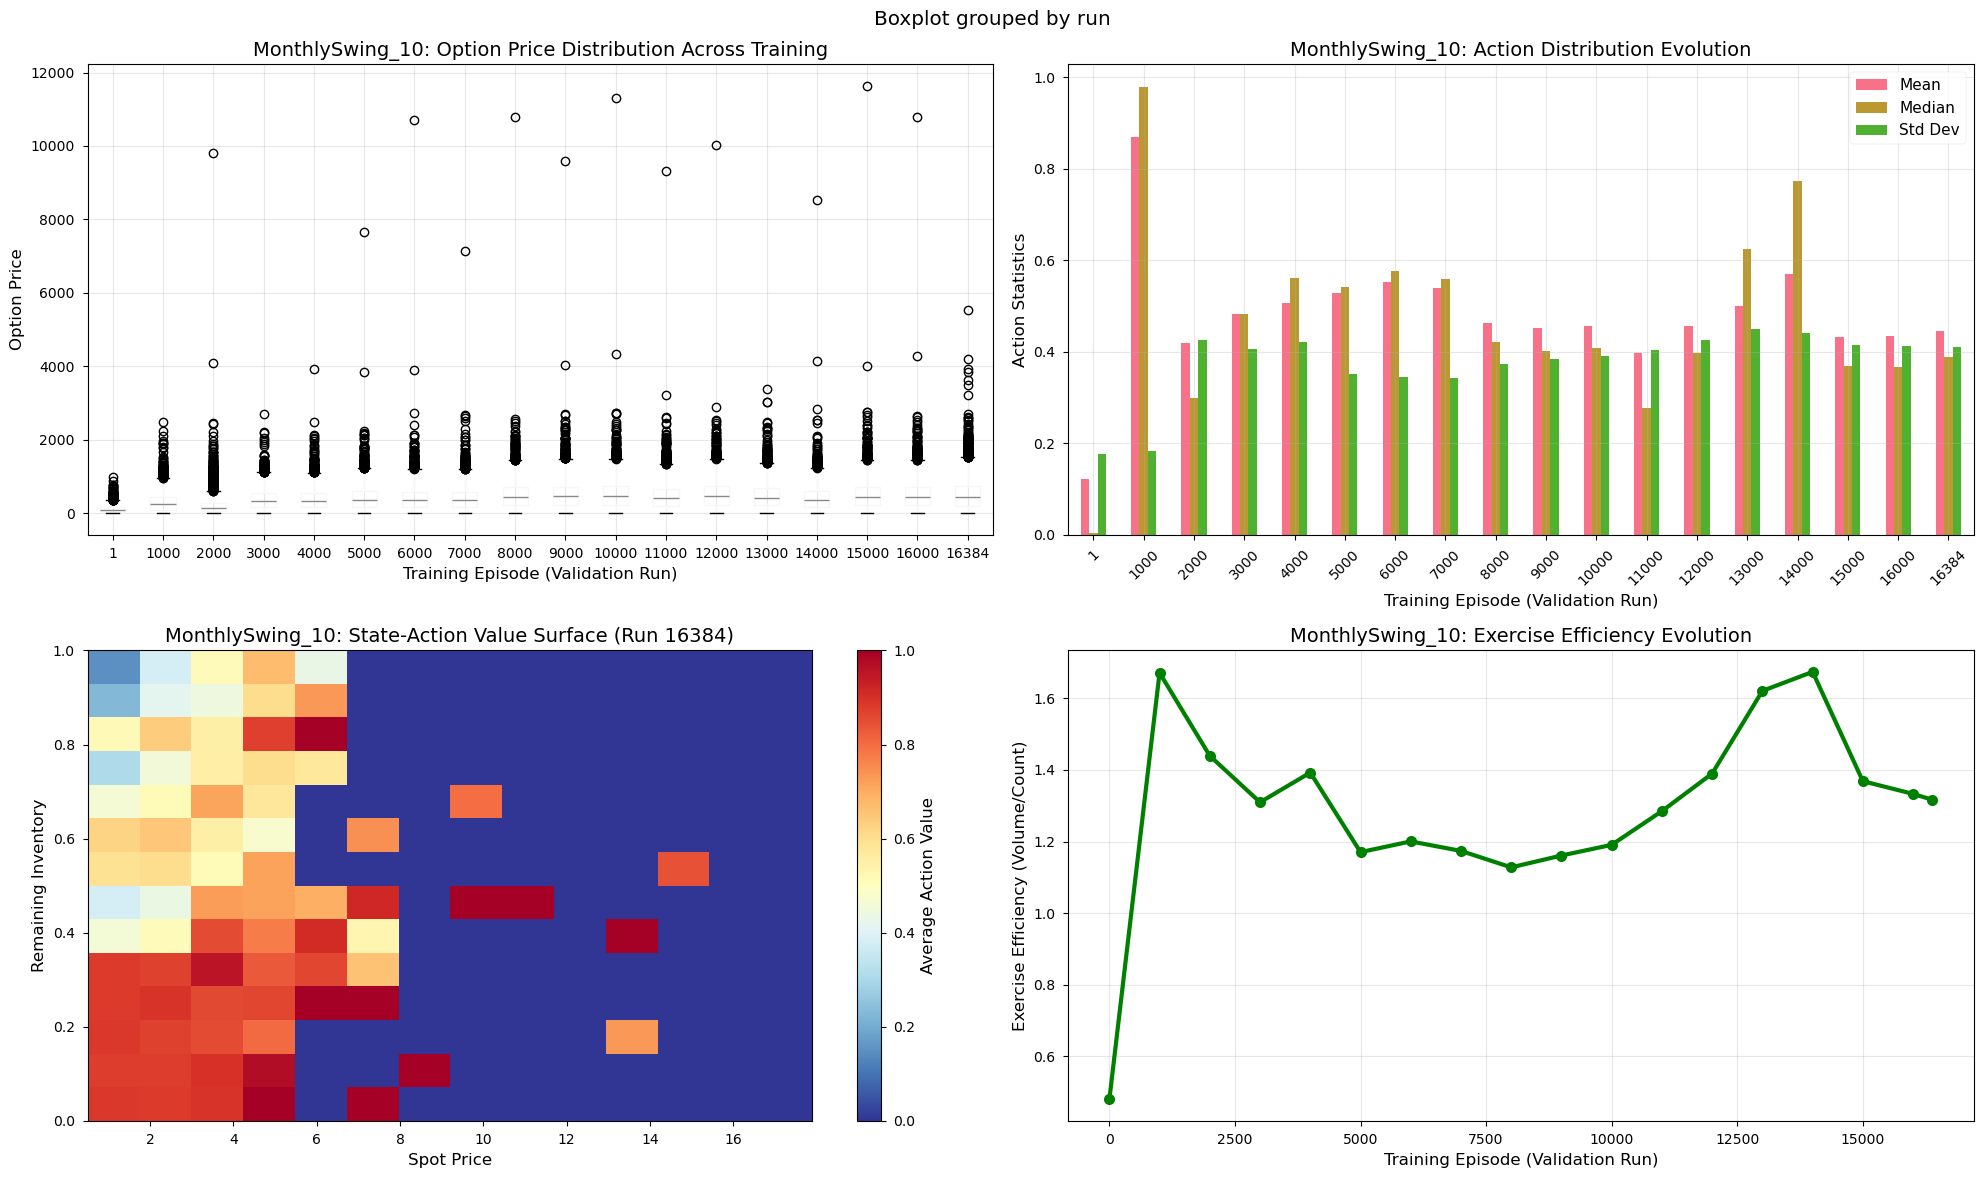

\nLearning Progression Analysis (MonthlySwing_10):
Validation runs analyzed: [1, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 16384]
Option price progression: 119.49 → 519.62
Action mean progression: 0.121 → 0.444
Exercise efficiency progression: 0.480 → 1.316


In [23]:
if validation_data:
    # Compare multiple validation runs to show learning progression
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
    
    # 1. Learning progression: Option pricing across validation runs
    validation_runs = sorted(validation_data.keys())
    option_prices = []
    run_episodes = []
    
    for run in validation_runs:
        val_data = validation_data[run]
        # Calculate option price for this run (sum of all rewards)
        episodes = val_data['episode_idx'].unique()
        run_option_prices = []
        for ep in episodes:
            ep_data = val_data[val_data['episode_idx'] == ep]
            option_price = ep_data['reward'].sum()
            run_option_prices.append(option_price)
        
        option_prices.extend(run_option_prices)
        run_episodes.extend([run] * len(run_option_prices))
    
    # Box plot showing option price distribution across runs
    runs_df = pd.DataFrame({'run': run_episodes, 'option_price': option_prices})
    runs_df.boxplot(column='option_price', by='run', ax=ax1)
    ax1.set_xlabel('Training Episode (Validation Run)')
    ax1.set_ylabel('Option Price')
    ax1.set_title(f'{EXPERIMENT_NAME}: Option Price Distribution Across Training')
    ax1.grid(True, alpha=0.3)
    
    # 2. Action distribution evolution
    action_evolution = {}
    for run in validation_runs:
        val_data = validation_data[run]
        action_evolution[run] = val_data['action'].describe()
    
    action_stats_df = pd.DataFrame(action_evolution).T
    action_stats_df[['mean', '50%', 'std']].plot(kind='bar', ax=ax2)
    ax2.set_xlabel('Training Episode (Validation Run)')
    ax2.set_ylabel('Action Statistics')
    ax2.set_title(f'{EXPERIMENT_NAME}: Action Distribution Evolution')
    ax2.legend(['Mean', 'Median', 'Std Dev'])
    ax2.grid(True, alpha=0.3)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    # 3. State-action value heatmap for the last validation run
    if not last_validation_data.empty:
        # Create state-action value surface
        state_bins = 15
        spot_range = np.linspace(last_validation_data['spot'].min(), last_validation_data['spot'].max(), state_bins)
        inventory_range = np.linspace(last_validation_data['q_remain'].min(), last_validation_data['q_remain'].max(), state_bins)
        
        value_surface = np.zeros((state_bins-1, state_bins-1))
        for i in range(state_bins-1):
            for j in range(state_bins-1):
                mask = ((last_validation_data['spot'] >= spot_range[i]) & 
                       (last_validation_data['spot'] < spot_range[i+1]) &
                       (last_validation_data['q_remain'] >= inventory_range[j]) & 
                       (last_validation_data['q_remain'] < inventory_range[j+1]))
                if mask.sum() > 0:
                    value_surface[i, j] = last_validation_data.loc[mask, 'action'].mean()
        
        im = ax3.imshow(value_surface.T, aspect='auto', origin='lower', cmap='RdYlBu_r',
                       extent=[spot_range[0], spot_range[-1], inventory_range[0], inventory_range[-1]])
        ax3.set_xlabel('Spot Price')
        ax3.set_ylabel('Remaining Inventory')
        ax3.set_title(f'{EXPERIMENT_NAME}: State-Action Value Surface (Run {last_validation_run})')
        plt.colorbar(im, ax=ax3, label='Average Action Value')
    
    # 4. Exercise efficiency across training
    exercise_efficiency = {}
    for run in validation_runs:
        val_data = validation_data[run]
        episodes = val_data['episode_idx'].unique()
        efficiencies = []
        for ep in episodes:
            ep_data = val_data[val_data['episode_idx'] == ep]
            total_exercised = ep_data['q_actual'].sum()
            exercise_count = (ep_data['q_actual'] > 0).sum()
            if exercise_count > 0:
                efficiency = total_exercised / exercise_count
                efficiencies.append(efficiency)
        exercise_efficiency[run] = np.mean(efficiencies) if efficiencies else 0
    
    ax4.plot(list(exercise_efficiency.keys()), list(exercise_efficiency.values()), 
            'o-', linewidth=3, markersize=8, color='green')
    ax4.set_xlabel('Training Episode (Validation Run)')
    ax4.set_ylabel('Exercise Efficiency (Volume/Count)')
    ax4.set_title(f'{EXPERIMENT_NAME}: Exercise Efficiency Evolution')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print learning progression summary
    print(f"\\nLearning Progression Analysis ({EXPERIMENT_NAME}):")
    print(f"Validation runs analyzed: {validation_runs}")
    print(f"Option price progression: {runs_df.groupby('run')['option_price'].mean().iloc[0]:.2f} → {runs_df.groupby('run')['option_price'].mean().iloc[-1]:.2f}")
    print(f"Action mean progression: {action_stats_df['mean'].iloc[0]:.3f} → {action_stats_df['mean'].iloc[-1]:.3f}")
    print(f"Exercise efficiency progression: {list(exercise_efficiency.values())[0]:.3f} → {list(exercise_efficiency.values())[-1]:.3f}")
else:
    print("No validation data available for learning progression analysis")

## 9. Temporal Dynamics and Market Regime Analysis

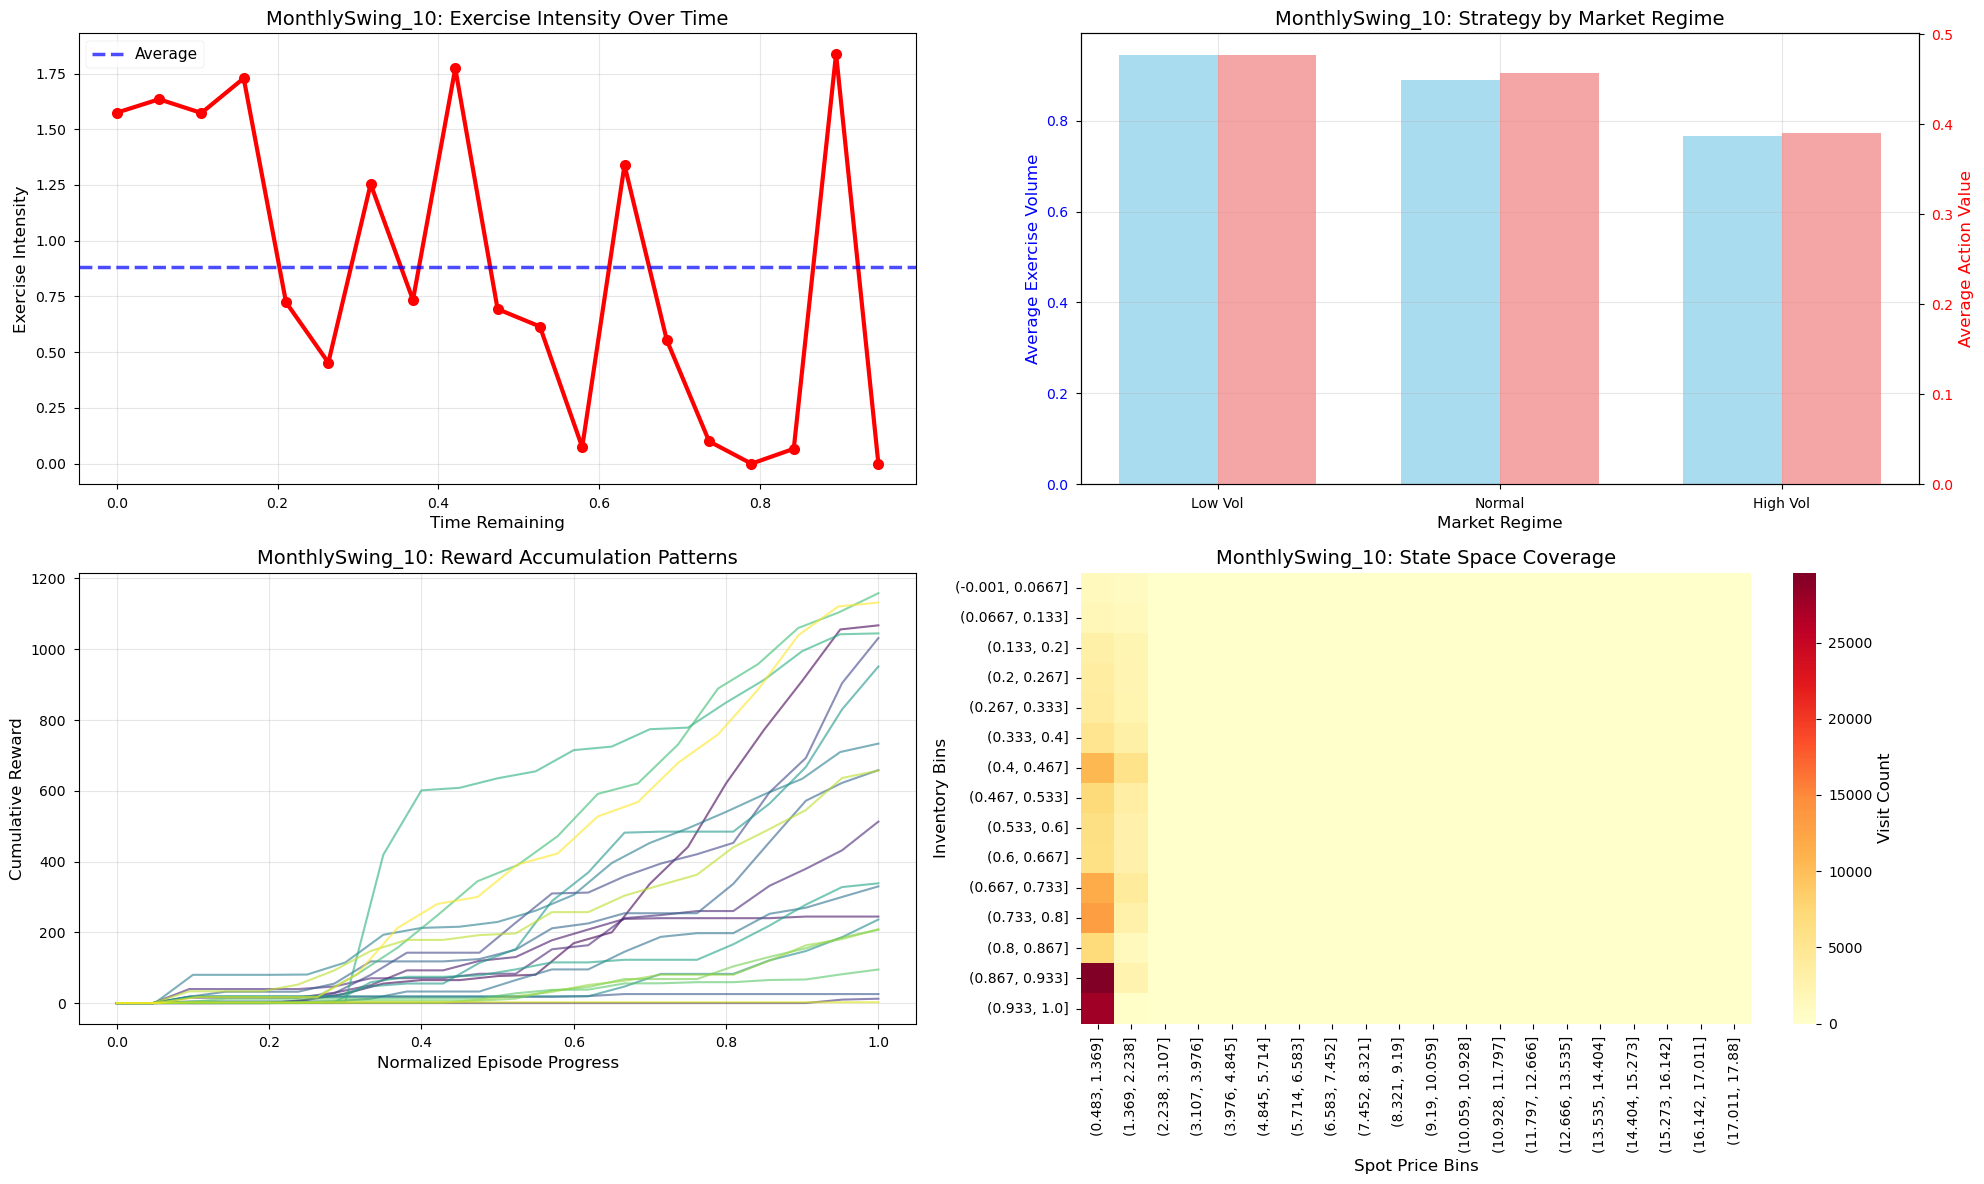

\nTemporal Dynamics Analysis (MonthlySwing_10 - Run 16384):
\nExercise Timing:
  - Early exercise intensity: 1.4469
  - Late exercise intensity: 0.4010
  - Timing preference: Early
\nMarket Regime Analysis:
  - Low Vol: Avg Exercise = 0.9450, Avg Action = 0.4770
  - Normal: Avg Exercise = 0.8900, Avg Action = 0.4570
  - High Vol: Avg Exercise = 0.7670, Avg Action = 0.3900
\nState Space Coverage: 35.67% (107/300 states visited)


In [24]:
if not last_validation_data.empty:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
    
    # 1. Intra-episode dynamics: Exercise decisions over time
    time_exercise_analysis = []
    for episode_idx in last_validation_data['episode_idx'].unique()[:50]:  # Sample 50 episodes
        episode_data = last_validation_data[last_validation_data['episode_idx'] == episode_idx]
        for _, row in episode_data.iterrows():
            time_exercise_analysis.append({
                'time_left': row['time_left'],
                'spot': row['spot'],
                'action': row['action'],
                'q_actual': row['q_actual'],
                'reward': row['reward'],
                'q_remain': row['q_remain']
            })
    
    dynamics_df = pd.DataFrame(time_exercise_analysis)
    
    # Time-based exercise intensity
    time_bins = np.linspace(0, 1, 20)
    exercise_intensity = []
    for i in range(len(time_bins)-1):
        mask = (dynamics_df['time_left'] >= time_bins[i]) & (dynamics_df['time_left'] < time_bins[i+1])
        intensity = dynamics_df.loc[mask, 'q_actual'].sum() / mask.sum() if mask.sum() > 0 else 0
        exercise_intensity.append(intensity)
    
    ax1.plot(time_bins[:-1], exercise_intensity, 'o-', linewidth=3, markersize=8, color='red')
    ax1.set_xlabel('Time Remaining')
    ax1.set_ylabel('Exercise Intensity')
    ax1.set_title(f'{EXPERIMENT_NAME}: Exercise Intensity Over Time')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=np.mean(exercise_intensity), color='blue', linestyle='--', alpha=0.7, label='Average')
    ax1.legend()
    
    # 2. Market regime identification based on spot price volatility
    volatility_window = 10
    dynamics_df['spot_volatility'] = dynamics_df['spot'].rolling(volatility_window, min_periods=1).std()
    volatility_threshold_high = dynamics_df['spot_volatility'].quantile(0.7)
    volatility_threshold_low = dynamics_df['spot_volatility'].quantile(0.3)
    
    # Classify market regimes
    dynamics_df['market_regime'] = 'Normal'
    dynamics_df.loc[dynamics_df['spot_volatility'] > volatility_threshold_high, 'market_regime'] = 'High Vol'
    dynamics_df.loc[dynamics_df['spot_volatility'] < volatility_threshold_low, 'market_regime'] = 'Low Vol'
    
    # Exercise behavior by market regime
    regime_exercise = dynamics_df.groupby('market_regime').agg({
        'q_actual': ['mean', 'std'],
        'action': ['mean', 'std'],
        'reward': ['mean', 'sum']
    }).round(3)
    
    regimes = ['Low Vol', 'Normal', 'High Vol']
    exercise_means = [regime_exercise.loc[r, ('q_actual', 'mean')] if r in regime_exercise.index else 0 for r in regimes]
    action_means = [regime_exercise.loc[r, ('action', 'mean')] if r in regime_exercise.index else 0 for r in regimes]
    
    x = np.arange(len(regimes))
    width = 0.35
    
    ax2.bar(x - width/2, exercise_means, width, label='Exercise Volume', color='skyblue', alpha=0.7)
    ax2_twin = ax2.twinx()
    ax2_twin.bar(x + width/2, action_means, width, label='Action Value', color='lightcoral', alpha=0.7)
    
    ax2.set_xlabel('Market Regime')
    ax2.set_ylabel('Average Exercise Volume', color='blue')
    ax2_twin.set_ylabel('Average Action Value', color='red')
    ax2.set_title(f'{EXPERIMENT_NAME}: Strategy by Market Regime')
    ax2.set_xticks(x)
    ax2.set_xticklabels(regimes)
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2_twin.tick_params(axis='y', labelcolor='red')
    ax2.grid(True, alpha=0.3)
    
    # 3. Reward accumulation patterns
    sample_episodes = last_validation_data['episode_idx'].unique()[:20]
    colors = plt.cm.viridis(np.linspace(0, 1, len(sample_episodes)))
    
    for i, episode_idx in enumerate(sample_episodes):
        episode_data = last_validation_data[last_validation_data['episode_idx'] == episode_idx]
        cumulative_reward = episode_data['reward'].cumsum()
        normalized_steps = episode_data['step'] / episode_data['step'].max()
        ax3.plot(normalized_steps, cumulative_reward, alpha=0.6, color=colors[i], linewidth=1.5)
    
    ax3.set_xlabel('Normalized Episode Progress')
    ax3.set_ylabel('Cumulative Reward')
    ax3.set_title(f'{EXPERIMENT_NAME}: Reward Accumulation Patterns')
    ax3.grid(True, alpha=0.3)
    
    # 4. State space coverage analysis
    # Plot the coverage of (spot, inventory) state space
    spot_inventory_coverage = last_validation_data.groupby([
        pd.cut(last_validation_data['spot'], bins=20),
        pd.cut(last_validation_data['q_remain'], bins=15)
    ]).size().reset_index(name='count')
    
    # Create pivot table for heatmap
    coverage_pivot = last_validation_data.pivot_table(
        values='action', 
        index=pd.cut(last_validation_data['q_remain'], bins=15),
        columns=pd.cut(last_validation_data['spot'], bins=20),
        aggfunc='count',
        fill_value=0
    )
    
    sns.heatmap(coverage_pivot, cmap='YlOrRd', ax=ax4, cbar_kws={'label': 'Visit Count'})
    ax4.set_xlabel('Spot Price Bins')
    ax4.set_ylabel('Inventory Bins')
    ax4.set_title(f'{EXPERIMENT_NAME}: State Space Coverage')
    
    plt.tight_layout()
    plt.show()
    
    # Print temporal analysis summary
    print(f"\\nTemporal Dynamics Analysis ({EXPERIMENT_NAME} - Run {last_validation_run}):")
    print(f"\\nExercise Timing:")
    early_exercise = np.mean([x for x in exercise_intensity[:5]])  # First 25% of time
    late_exercise = np.mean([x for x in exercise_intensity[-5:]])  # Last 25% of time
    print(f"  - Early exercise intensity: {early_exercise:.4f}")
    print(f"  - Late exercise intensity: {late_exercise:.4f}")
    print(f"  - Timing preference: {'Early' if early_exercise > late_exercise else 'Late'}")
    
    print(f"\\nMarket Regime Analysis:")
    for regime in regimes:
        if regime in regime_exercise.index:
            print(f"  - {regime}: Avg Exercise = {regime_exercise.loc[regime, ('q_actual', 'mean')]:.4f}, Avg Action = {regime_exercise.loc[regime, ('action', 'mean')]:.4f}")
    
    # State space utilization
    total_states = coverage_pivot.size
    visited_states = (coverage_pivot > 0).sum().sum()
    coverage_ratio = visited_states / total_states
    print(f"\\nState Space Coverage: {coverage_ratio:.2%} ({visited_states}/{total_states} states visited)")
    
else:
    print("No validation data available for temporal dynamics analysis")

## 10. Policy Analysis and Trading Recommendations

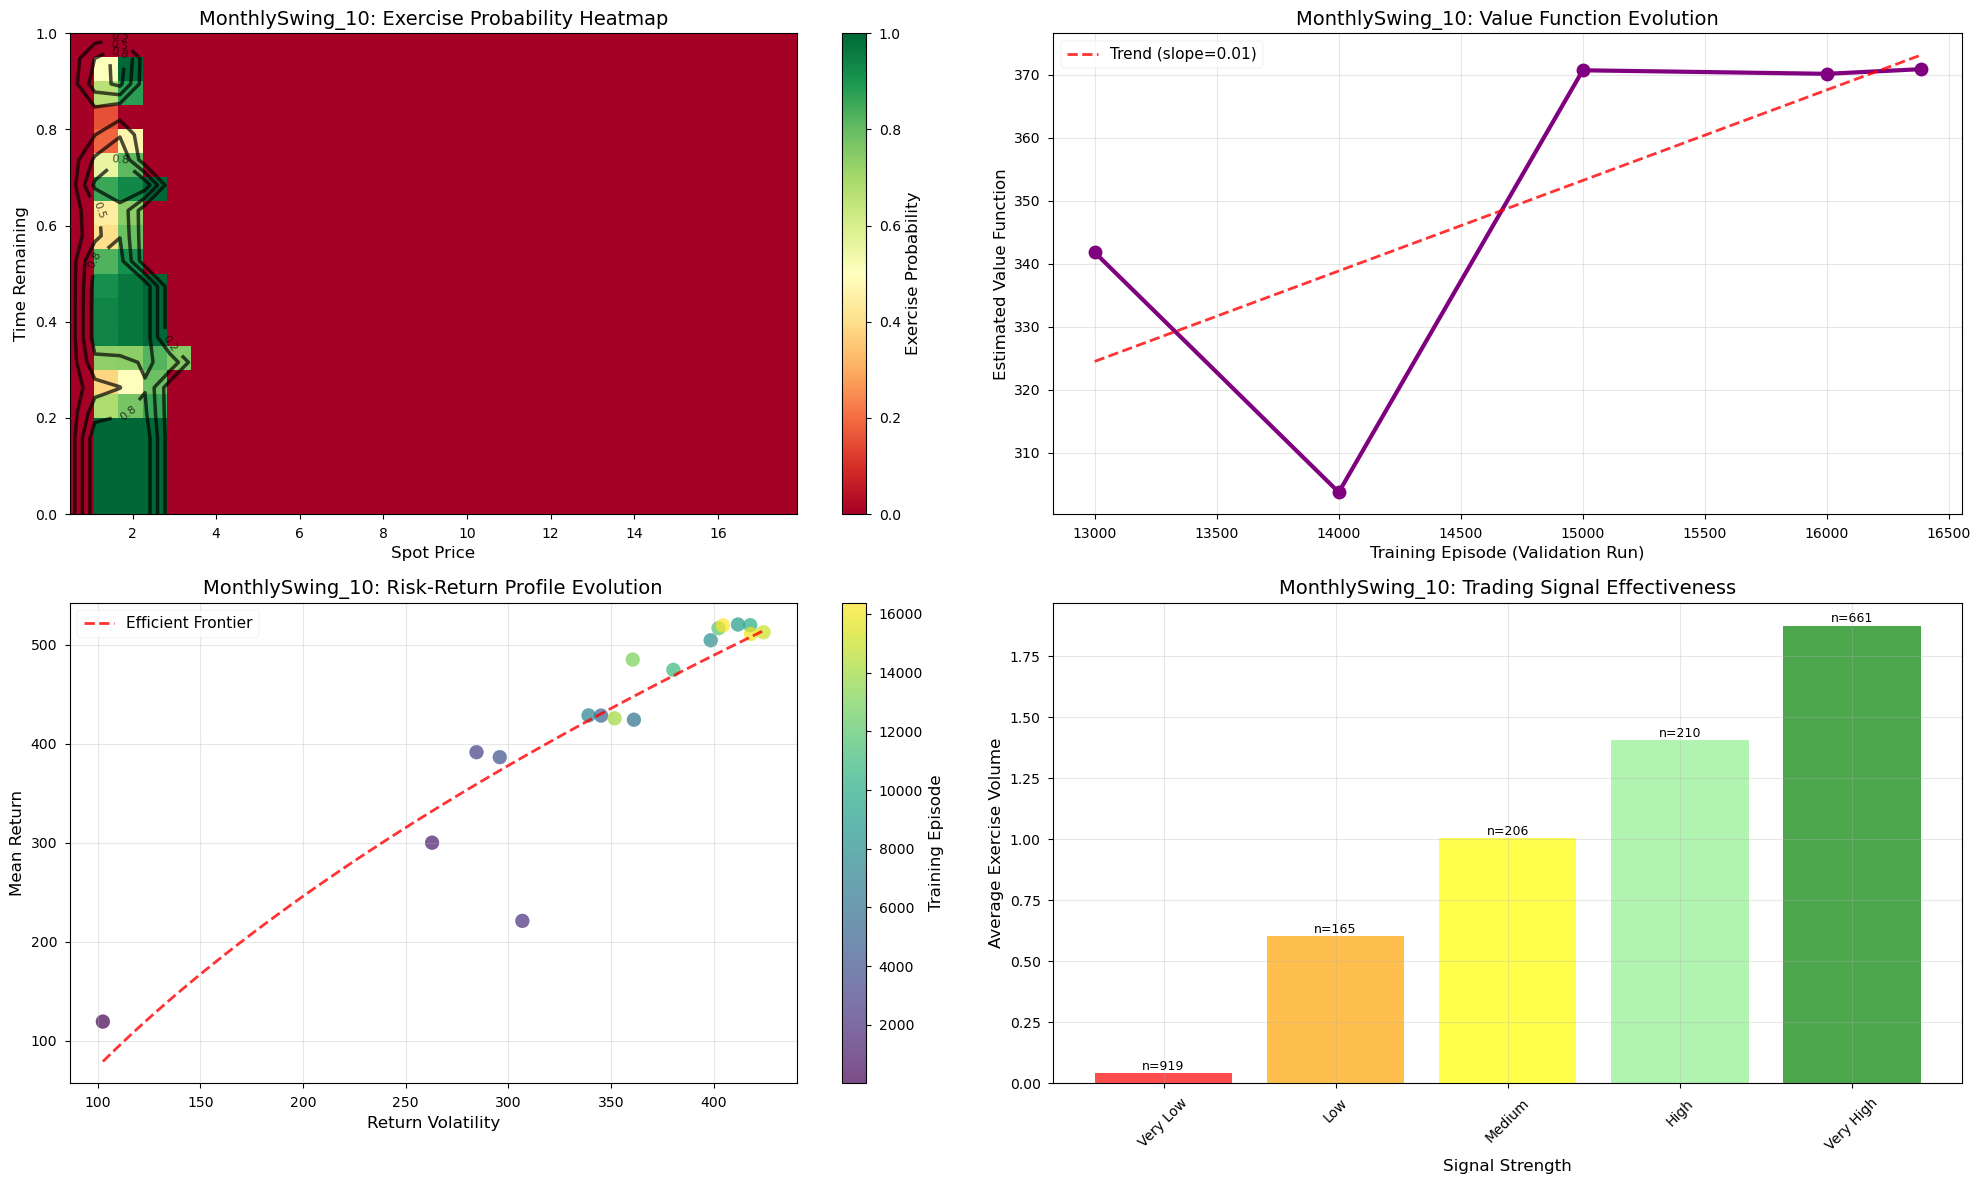

COMPREHENSIVE TRADING ANALYSIS AND RECOMMENDATIONS - MonthlySwing_10
\n🎯 POLICY ANALYSIS:
   • Final Sharpe Ratio: 1.284
   • Return Volatility: 404.60
   • Value at Risk (5%): 30.14
\n📈 EXERCISE STRATEGY INSIGHTS:
   • Exercise zone coverage: 7.0% of state space
   • Strategy type: Conservative
   • Signal discrimination power: 1.8327
   • Signal quality: Excellent
\n💼 TRADING RECOMMENDATIONS:
   ✅ BUY: Good risk-adjusted returns, moderate allocation recommended
\n🔧 OPTIMIZATION SUGGESTIONS:
   • Value function is improving - continue current training approach
   • Exercise boundary analysis suggests early exercise bias
   • State space coverage: 35.7% - Need more exploration
\n====================================================================================================


In [25]:
if not last_validation_data.empty and validation_data:
    # Policy gradient analysis and optimal exercise boundary estimation
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
    
    # 1. Optimal exercise boundary estimation
    spot_range = np.linspace(last_validation_data['spot'].min(), last_validation_data['spot'].max(), 30)
    time_range = np.linspace(0, 1, 20)
    
    exercise_boundary = np.zeros((len(time_range), len(spot_range)))
    for i, time_left in enumerate(time_range):
        for j, spot in enumerate(spot_range):
            # Find similar states and average exercise decision
            time_mask = np.abs(last_validation_data['time_left'] - time_left) < 0.05
            spot_mask = np.abs(last_validation_data['spot'] - spot) < 0.02
            mask = time_mask & spot_mask
            
            if mask.sum() > 5:  # Require at least 5 observations
                exercise_boundary[i, j] = (last_validation_data.loc[mask, 'q_actual'] > 0).mean()
    
    im1 = ax1.imshow(exercise_boundary, aspect='auto', origin='lower', cmap='RdYlGn',
                    extent=[spot_range[0], spot_range[-1], 0, 1])
    ax1.set_xlabel('Spot Price')
    ax1.set_ylabel('Time Remaining')
    ax1.set_title(f'{EXPERIMENT_NAME}: Exercise Probability Heatmap')
    plt.colorbar(im1, ax=ax1, label='Exercise Probability')
    
    # Add contour lines for exercise boundaries
    contours = ax1.contour(spot_range, time_range, exercise_boundary, levels=[0.2, 0.5, 0.8], colors='black', alpha=0.7)
    ax1.clabel(contours, inline=True, fontsize=8)
    
    # 2. Value function approximation across training
    validation_runs = sorted(validation_data.keys())
    value_evolution = {}
    
    for run in validation_runs[-5:]:  # Last 5 runs
        val_data = validation_data[run]
        # Approximate value function as cumulative reward from each state
        episode_values = []
        for episode_idx in val_data['episode_idx'].unique()[:100]:  # Sample episodes
            episode_data = val_data[val_data['episode_idx'] == episode_idx]
            for idx, row in episode_data.iterrows():
                remaining_reward = episode_data.loc[idx:, 'reward'].sum()
                episode_values.append(remaining_reward)
        value_evolution[run] = np.mean(episode_values) if episode_values else 0
    
    ax2.plot(list(value_evolution.keys()), list(value_evolution.values()), 
            'o-', linewidth=3, markersize=10, color='purple')
    ax2.set_xlabel('Training Episode (Validation Run)')
    ax2.set_ylabel('Estimated Value Function')
    ax2.set_title(f'{EXPERIMENT_NAME}: Value Function Evolution')
    ax2.grid(True, alpha=0.3)
    
    # Add trend line
    x_vals = np.array(list(value_evolution.keys()))
    y_vals = np.array(list(value_evolution.values()))
    if len(x_vals) > 1:
        z = np.polyfit(x_vals, y_vals, 1)
        p = np.poly1d(z)
        ax2.plot(x_vals, p(x_vals), "r--", alpha=0.8, linewidth=2, 
                label=f'Trend (slope={z[0]:.2f})')
        ax2.legend()
    
    # 3. Risk-adjusted performance metrics
    performance_metrics = {}
    for run in validation_runs:
        val_data = validation_data[run]
        episodes = val_data['episode_idx'].unique()
        returns = []
        for ep in episodes:
            ep_data = val_data[val_data['episode_idx'] == ep]
            episode_return = ep_data['reward'].sum()
            returns.append(episode_return)
        
        if returns:
            mean_return = np.mean(returns)
            vol_return = np.std(returns)
            sharpe = mean_return / vol_return if vol_return > 0 else 0
            var_95 = np.percentile(returns, 5)
            performance_metrics[run] = {
                'mean_return': mean_return,
                'volatility': vol_return,
                'sharpe': sharpe,
                'var_95': var_95
            }
    
    # Plot risk-return profile
    if performance_metrics:
        risks = [metrics['volatility'] for metrics in performance_metrics.values()]
        returns = [metrics['mean_return'] for metrics in performance_metrics.values()]
        runs = list(performance_metrics.keys())
        
        scatter = ax3.scatter(risks, returns, c=runs, cmap='viridis', s=100, alpha=0.7)
        ax3.set_xlabel('Return Volatility')
        ax3.set_ylabel('Mean Return')
        ax3.set_title(f'{EXPERIMENT_NAME}: Risk-Return Profile Evolution')
        ax3.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax3, label='Training Episode')
        
        # Add efficient frontier approximation
        if len(risks) > 2:
            from scipy.optimize import curve_fit
            def efficient_frontier(x, a, b):
                return a * np.sqrt(x) + b
            
            try:
                popt, _ = curve_fit(efficient_frontier, risks, returns)
                x_smooth = np.linspace(min(risks), max(risks), 100)
                y_smooth = efficient_frontier(x_smooth, *popt)
                ax3.plot(x_smooth, y_smooth, 'r--', alpha=0.8, linewidth=2, label='Efficient Frontier')
                ax3.legend()
            except:
                pass
    
    # 4. Trading signal analysis
    # Generate trading signals based on learned policy
    signal_data = []
    for episode_idx in last_validation_data['episode_idx'].unique()[:100]:
        episode_data = last_validation_data[last_validation_data['episode_idx'] == episode_idx].reset_index(drop=True)
        
        for position, row in episode_data.iterrows():
            # Define signal strength based on action magnitude and context
            signal_strength = row['action']
            spot_momentum = 0
            if position > 0:  # Use position instead of idx
                prev_spot = episode_data.iloc[position-1]['spot']
                spot_momentum = (row['spot'] - prev_spot) / prev_spot
            
            signal_data.append({
                'spot': row['spot'],
                'time_left': row['time_left'],
                'signal_strength': signal_strength,
                'q_actual': row['q_actual'],
                'spot_momentum': spot_momentum,
                'inventory_level': row['q_remain']
            })
    
    signals_df = pd.DataFrame(signal_data)
    
    # Create signal strength bins
    signals_df['signal_bin'] = pd.cut(signals_df['signal_strength'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    
    # Analyze signal effectiveness
    signal_effectiveness = signals_df.groupby('signal_bin').agg({
        'q_actual': ['mean', 'count'],
        'spot_momentum': 'mean'
    }).round(4)
    
    # Plot signal analysis
    signal_labels = signal_effectiveness.index
    signal_exercise = signal_effectiveness[('q_actual', 'mean')].values
    signal_counts = signal_effectiveness[('q_actual', 'count')].values
    
    bars = ax4.bar(range(len(signal_labels)), signal_exercise, 
                  color=['red', 'orange', 'yellow', 'lightgreen', 'green'], alpha=0.7)
    ax4.set_xlabel('Signal Strength')
    ax4.set_ylabel('Average Exercise Volume')
    ax4.set_title(f'{EXPERIMENT_NAME}: Trading Signal Effectiveness')
    ax4.set_xticks(range(len(signal_labels)))
    ax4.set_xticklabels(signal_labels, rotation=45)
    ax4.grid(True, alpha=0.3)
    
    # Add count labels on bars
    for i, (bar, count) in enumerate(zip(bars, signal_counts)):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.001, 
                f'n={count}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive trading recommendations
    print("="*100)
    print(f"COMPREHENSIVE TRADING ANALYSIS AND RECOMMENDATIONS - {EXPERIMENT_NAME}")
    print("="*100)
    
    print(f"\\n🎯 POLICY ANALYSIS:")
    if performance_metrics:
        final_metrics = performance_metrics[max(performance_metrics.keys())]
        print(f"   • Final Sharpe Ratio: {final_metrics['sharpe']:.3f}")
        print(f"   • Return Volatility: {final_metrics['volatility']:.2f}")
        print(f"   • Value at Risk (5%): {final_metrics['var_95']:.2f}")
    
    print(f"\\n📈 EXERCISE STRATEGY INSIGHTS:")
    high_prob_zones = (exercise_boundary > 0.5).sum()
    total_zones = exercise_boundary.size
    exercise_coverage = high_prob_zones / total_zones
    print(f"   • Exercise zone coverage: {exercise_coverage:.1%} of state space")
    print(f"   • Strategy type: {'Aggressive' if exercise_coverage > 0.3 else 'Conservative' if exercise_coverage < 0.1 else 'Balanced'}")
    
    # Signal analysis
    if not signals_df.empty:
        high_signal_effectiveness = signal_effectiveness.loc['Very High', ('q_actual', 'mean')] if 'Very High' in signal_effectiveness.index else 0
        low_signal_effectiveness = signal_effectiveness.loc['Very Low', ('q_actual', 'mean')] if 'Very Low' in signal_effectiveness.index else 0
        signal_discrimination = high_signal_effectiveness - low_signal_effectiveness
        print(f"   • Signal discrimination power: {signal_discrimination:.4f}")
        print(f"   • Signal quality: {'Excellent' if signal_discrimination > 0.1 else 'Good' if signal_discrimination > 0.05 else 'Needs improvement'}")
    
    print(f"\\n💼 TRADING RECOMMENDATIONS:")
    if performance_metrics:
        latest_sharpe = list(performance_metrics.values())[-1]['sharpe']
        if latest_sharpe > 1.5:
            print("   ✅ STRONG BUY: Excellent risk-adjusted returns, suitable for increased allocation")
        elif latest_sharpe > 1.0:
            print("   ✅ BUY: Good risk-adjusted returns, moderate allocation recommended")
        elif latest_sharpe > 0.5:
            print("   ⚠️  HOLD: Acceptable performance, monitor closely")
        else:
            print("   ❌ AVOID: Poor risk-adjusted returns, strategy needs refinement")
    
    print(f"\\n🔧 OPTIMIZATION SUGGESTIONS:")
    if value_evolution:
        value_trend = list(value_evolution.values())[-1] - list(value_evolution.values())[0]
        if value_trend > 0:
            print("   • Value function is improving - continue current training approach")
        else:
            print("   • Value function stagnating - consider hyperparameter tuning")
    
    print(f"   • Exercise boundary analysis suggests {'early exercise bias' if np.mean(exercise_boundary[:5, :]) > np.mean(exercise_boundary[-5:, :]) else 'late exercise bias'}")
    
    # Fix the coverage_ratio reference - it should be calculated in this cell
    # Get coverage ratio from the state space coverage analysis
    coverage_pivot = last_validation_data.pivot_table(
        values='action', 
        index=pd.cut(last_validation_data['q_remain'], bins=15),
        columns=pd.cut(last_validation_data['spot'], bins=20),
        aggfunc='count',
        fill_value=0
    )
    total_states = coverage_pivot.size
    visited_states = (coverage_pivot > 0).sum().sum()
    coverage_ratio = visited_states / total_states
    
    print(f"   • State space coverage: {coverage_ratio:.1%} - {'Good exploration' if coverage_ratio > 0.7 else 'Need more exploration'}")
    
    print("\\n" + "="*100)
    
else:
    print("Insufficient validation data for comprehensive policy analysis")

DERIVATIVE PAYOFF ANALYSIS: TEMPORAL STABILITY OF SWING OPTION STRATEGIES - MonthlySwing_10

📊 SWING OPTION PAYOFF DISTRIBUTIONS:
Total validation runs analyzed: 18
Run     1: 4096 paths | Mean:  119.491 [ 116.368,  122.628] | Max Payout (95%):  313.081 | P(Payout): 98.7%
Run  1000: 4096 paths | Mean:  300.182 [ 292.168,  308.295] | Max Payout (95%):  776.133 | P(Payout): 96.9%
Run  2000: 4096 paths | Mean:  221.242 [ 212.043,  231.054] | Max Payout (95%):  769.723 | P(Payout): 96.5%
Run  3000: 4096 paths | Mean:  391.596 [ 382.862,  400.407] | Max Payout (95%):  903.977 | P(Payout): 99.3%
Run  4000: 4096 paths | Mean:  386.590 [ 377.368,  395.856] | Max Payout (95%):  914.822 | P(Payout): 99.0%
Run  5000: 4096 paths | Mean:  428.537 [ 418.261,  439.365] | Max Payout (95%): 1021.809 | P(Payout): 99.1%
Run  6000: 4096 paths | Mean:  424.371 [ 413.619,  435.714] | Max Payout (95%): 1009.282 | P(Payout): 99.1%
Run  7000: 4096 paths | Mean:  428.739 [ 418.500,  439.151] | Max Payout (95%):

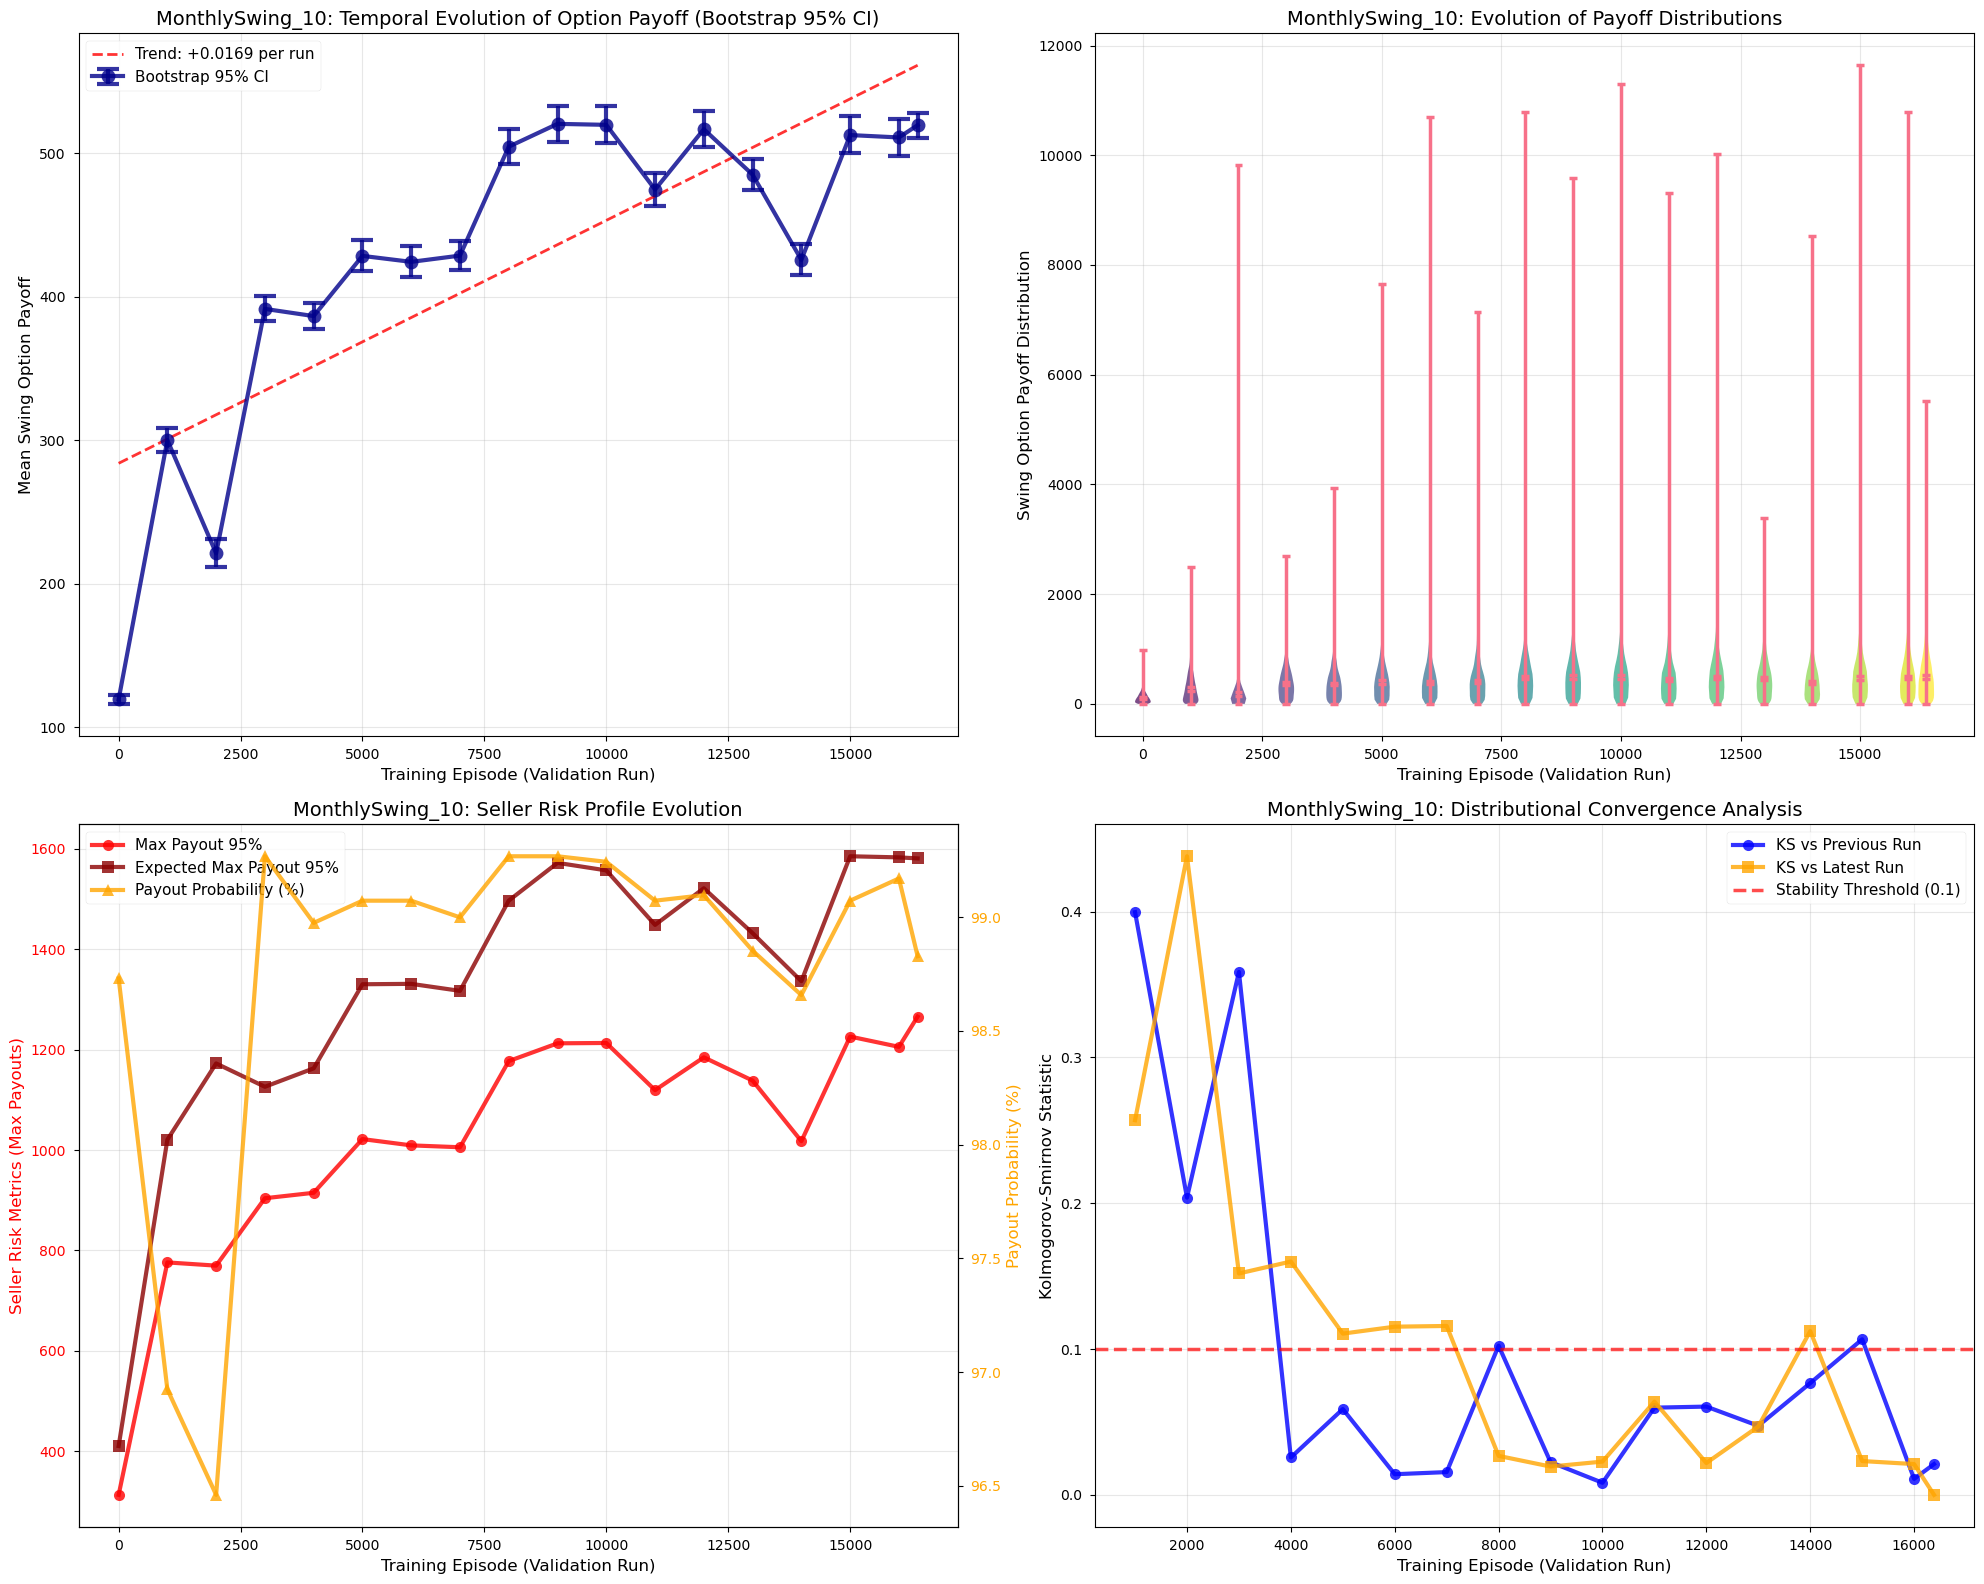


📈 SWING OPTION STRATEGY STABILITY ASSESSMENT:
\nLearning Phase Analysis (Runs 1-8000):
   • Mean Payoff:  356.152 ± 113.886
   • Avg CI Width:  18.399
   • Stability (CoV): 0.3198
\nMature Phase Analysis (Runs 9000-16384):
   • Mean Payoff:  498.472 ± 30.032
   • Avg CI Width:  23.503
   • Stability (CoV): 0.0602
\nLearning Progress: IMPROVED (Statistically Significant) (p=0.0020)
\n🟢 FINAL STABILITY ASSESSMENT: HIGHLY STABLE
Recent Stability (CoV): 0.0072
Recommendation: Strategy is ready for production deployment with high confidence
\n⚠️  DERIVATIVE SELLER RISK PROFILE (Latest Run):
   • Sharpe Ratio:  1.284
   • Payout Probability: 98.8%
   • Maximum Payout 95%: 1265.833
   • Expected Maximum Payout 95%: 1580.935
   • Tail Risk (Skew/Kurt):  1.567 /  6.828
\n====================================================================================================


In [26]:
## 11. Derivative Payoff Distribution Analysis: Temporal Stability with Bootstrap Confidence Intervals

import scipy.stats as stats
from scipy.stats import ks_2samp
import warnings
warnings.filterwarnings('ignore')

def bootstrap_mean_ci(data, n_bootstrap=10000, confidence_level=0.95):
    """
    Calculate bootstrap confidence interval for the mean of derivative payoffs.
    High volatility is expected for derivative payoff distributions.
    """
    if len(data) == 0:
        return np.nan, np.nan, np.nan
    
    bootstrap_means = []
    n = len(data)
    
    # Generate bootstrap samples
    np.random.seed(42)  # For reproducibility
    for _ in range(n_bootstrap):
        bootstrap_sample = np.random.choice(data, size=n, replace=True)
        bootstrap_means.append(np.mean(bootstrap_sample))
    
    bootstrap_means = np.array(bootstrap_means)
    alpha = 1 - confidence_level
    
    # Calculate percentile-based confidence interval
    lower_percentile = (alpha/2) * 100
    upper_percentile = (1 - alpha/2) * 100
    
    ci_lower = np.percentile(bootstrap_means, lower_percentile)
    ci_upper = np.percentile(bootstrap_means, upper_percentile)
    
    return np.mean(data), ci_lower, ci_upper

def calculate_derivative_risk_metrics(payoffs):
    """
    Calculate risk metrics for derivative seller's perspective.
    Focus on maximum payouts (right tail) that seller must pay.
    """
    if len(payoffs) == 0:
        return {}
    
    # Basic statistics
    mean_payoff = np.mean(payoffs)
    std_payoff = np.std(payoffs)
    
    # Seller's risk metrics - maximum payouts (right tail)
    var_95 = np.percentile(payoffs, 95)  # 95th percentile - potential max payout (95% confidence)
    var_99 = np.percentile(payoffs, 99)  # 99th percentile - potential max payout (99% confidence)
    
    # Expected Shortfall (Conditional VaR) - for seller's worst case scenarios
    es_95 = np.mean(payoffs[payoffs >= var_95]) if np.sum(payoffs >= var_95) > 0 else var_95
    es_99 = np.mean(payoffs[payoffs >= var_99]) if np.sum(payoffs >= var_99) > 0 else var_99
    
    # Tail statistics
    skewness = stats.skew(payoffs)
    kurtosis = stats.kurtosis(payoffs)
    
    # Loss probability for seller (probability of having to pay out)
    loss_prob = (payoffs > 0).mean()  # From seller's perspective, positive payoffs are losses
    
    return {
        'mean': mean_payoff,
        'std': std_payoff,
        'var_95': var_95,
        'var_99': var_99,
        'es_95': es_95,
        'es_99': es_99,
        'skewness': skewness,
        'kurtosis': kurtosis,
        'loss_prob': loss_prob,
        'sharpe_ratio': mean_payoff / std_payoff if std_payoff > 0 else 0
    }

if validation_data and len(validation_data) >= 2:
    print("="*100)
    print(f"DERIVATIVE PAYOFF ANALYSIS: TEMPORAL STABILITY OF SWING OPTION STRATEGIES - {EXPERIMENT_NAME}")
    print("="*100)
    
    # Calculate swing option payoffs (cumulative rewards) for each validation run
    validation_runs = sorted(validation_data.keys())
    payoff_distributions = {}
    bootstrap_results = {}
    risk_metrics = {}
    
    print(f"\n📊 SWING OPTION PAYOFF DISTRIBUTIONS:")
    print(f"Total validation runs analyzed: {len(validation_runs)}")
    
    for run in validation_runs:
        val_data = validation_data[run]
        episodes = val_data['episode_idx'].unique()
        payoffs = []
        
        # Calculate payoff for each episode (Monte Carlo path)
        for episode_idx in episodes:
            episode_data = val_data[val_data['episode_idx'] == episode_idx]
            swing_option_payoff = episode_data['reward'].sum()
            payoffs.append(swing_option_payoff)
        
        payoffs = np.array(payoffs)
        payoff_distributions[run] = payoffs
        
        # Bootstrap confidence intervals for mean payoff
        mean_payoff, ci_lower, ci_upper = bootstrap_mean_ci(payoffs)
        bootstrap_results[run] = {
            'mean': mean_payoff,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'ci_width': ci_upper - ci_lower
        }
        
        # Calculate derivative-specific risk metrics
        risk_metrics[run] = calculate_derivative_risk_metrics(payoffs)
        
        print(f"Run {run:5d}: {len(payoffs):3d} paths | "
              f"Mean: {mean_payoff:8.3f} [{ci_lower:8.3f}, {ci_upper:8.3f}] | "
              f"Max Payout (95%): {risk_metrics[run]['var_95']:8.3f} | "
              f"P(Payout): {risk_metrics[run]['loss_prob']:5.1%}")
    
    # Temporal stability analysis with rolling windows
    print(f"\n🔍 TEMPORAL STABILITY ANALYSIS:")
    
    # Analyze stability over consecutive runs
    window_size = 3  # Rolling window for stability assessment
    stability_metrics = []
    
    if len(validation_runs) >= window_size:
        for i in range(len(validation_runs) - window_size + 1):
            window_runs = validation_runs[i:i + window_size]
            window_means = [bootstrap_results[run]['mean'] for run in window_runs]
            window_ci_widths = [bootstrap_results[run]['ci_width'] for run in window_runs]
            
            # Stability metrics for this window
            mean_stability = np.std(window_means) / np.mean(np.abs(window_means)) if np.mean(np.abs(window_means)) > 0 else 0
            ci_stability = np.mean(window_ci_widths)
            
            stability_metrics.append({
                'center_run': window_runs[window_size//2],
                'mean_stability': mean_stability,
                'ci_width': ci_stability,
                'runs': window_runs
            })
            
            print(f"Runs {window_runs[0]}-{window_runs[-1]}: "
                  f"Mean Stability (CoV): {mean_stability:.4f} | "
                  f"Avg CI Width: {ci_stability:.3f}")
    
    # Visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    
    # 1. Bootstrap confidence intervals over time
    runs = list(bootstrap_results.keys())
    means = [bootstrap_results[run]['mean'] for run in runs]
    ci_lowers = [bootstrap_results[run]['ci_lower'] for run in runs]
    ci_uppers = [bootstrap_results[run]['ci_upper'] for run in runs]
    
    ax1.errorbar(runs, means, 
                yerr=[np.array(means) - np.array(ci_lowers), 
                      np.array(ci_uppers) - np.array(means)],
                capsize=8, capthick=3, linewidth=3, markersize=10, 
                marker='o', color='darkblue', alpha=0.8, label='Bootstrap 95% CI')
    
    # Add trend line
    if len(runs) > 2:
        z = np.polyfit(runs, means, 1)
        p = np.poly1d(z)
        ax1.plot(runs, p(runs), "r--", alpha=0.8, linewidth=2, 
                label=f'Trend: {z[0]:+.4f} per run')
    
    ax1.set_xlabel('Training Episode (Validation Run)')
    ax1.set_ylabel('Mean Swing Option Payoff')
    ax1.set_title(f'{EXPERIMENT_NAME}: Temporal Evolution of Option Payoff (Bootstrap 95% CI)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Payoff distribution evolution (violin plots for better visualization of derivative payoffs)
    violin_data = [payoff_distributions[run] for run in runs]
    parts = ax2.violinplot(violin_data, positions=runs, widths=max(runs)*0.02, showmeans=True, showmedians=True)
    
    # Color the violins
    colors = plt.cm.viridis(np.linspace(0, 1, len(runs)))
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
    
    ax2.set_xlabel('Training Episode (Validation Run)')
    ax2.set_ylabel('Swing Option Payoff Distribution')
    ax2.set_title(f'{EXPERIMENT_NAME}: Evolution of Payoff Distributions')
    ax2.grid(True, alpha=0.3)
    
    # 3. Risk metrics evolution (from seller's perspective)
    var_95_values = [risk_metrics[run]['var_95'] for run in runs]
    es_95_values = [risk_metrics[run]['es_95'] for run in runs]
    loss_probs = [risk_metrics[run]['loss_prob'] * 100 for run in runs]
    
    ax3_twin = ax3.twinx()
    
    line1 = ax3.plot(runs, var_95_values, 'o-', linewidth=3, markersize=8, 
                    color='red', alpha=0.8, label='Max Payout 95%')
    line2 = ax3.plot(runs, es_95_values, 's-', linewidth=3, markersize=8, 
                    color='darkred', alpha=0.8, label='Expected Max Payout 95%')
    line3 = ax3_twin.plot(runs, loss_probs, '^-', linewidth=3, markersize=8, 
                         color='orange', alpha=0.8, label='Payout Probability (%)')
    
    ax3.set_xlabel('Training Episode (Validation Run)')
    ax3.set_ylabel('Seller Risk Metrics (Max Payouts)', color='red')
    ax3_twin.set_ylabel('Payout Probability (%)', color='orange')
    ax3.set_title(f'{EXPERIMENT_NAME}: Seller Risk Profile Evolution')
    ax3.tick_params(axis='y', labelcolor='red')
    ax3_twin.tick_params(axis='y', labelcolor='orange')
    
    # Combine legends
    lines1, labels1 = ax3.get_legend_handles_labels()
    lines2, labels2 = ax3_twin.get_legend_handles_labels()
    ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    # 4. Distributional convergence analysis
    if len(validation_runs) >= 3:
        # Calculate KS statistics between consecutive runs and early vs late periods
        ks_stats_consecutive = []
        ks_stats_vs_latest = []
        
        for i in range(1, len(validation_runs)):
            # Consecutive runs
            ks_stat_cons, _ = ks_2samp(payoff_distributions[validation_runs[i-1]], 
                                      payoff_distributions[validation_runs[i]])
            ks_stats_consecutive.append(ks_stat_cons)
            
            # Each run vs latest run
            ks_stat_latest, _ = ks_2samp(payoff_distributions[validation_runs[i]], 
                                        payoff_distributions[validation_runs[-1]])
            ks_stats_vs_latest.append(ks_stat_latest)
        
        ax4.plot(validation_runs[1:], ks_stats_consecutive, 'o-', linewidth=3, markersize=8, 
                color='blue', alpha=0.8, label='KS vs Previous Run')
        ax4.plot(validation_runs[1:], ks_stats_vs_latest, 's-', linewidth=3, markersize=8, 
                color='orange', alpha=0.8, label='KS vs Latest Run')
        
        # Add stability threshold
        ax4.axhline(y=0.1, color='red', linestyle='--', alpha=0.7, 
                   label='Stability Threshold (0.1)')
        
        ax4.set_xlabel('Training Episode (Validation Run)')
        ax4.set_ylabel('Kolmogorov-Smirnov Statistic')
        ax4.set_title(f'{EXPERIMENT_NAME}: Distributional Convergence Analysis')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Comprehensive stability assessment
    print(f"\n📈 SWING OPTION STRATEGY STABILITY ASSESSMENT:")
    
    # Learning phase vs mature phase analysis
    if len(validation_runs) >= 6:
        early_runs = validation_runs[:len(validation_runs)//2]
        late_runs = validation_runs[len(validation_runs)//2:]
        
        early_means = [bootstrap_results[run]['mean'] for run in early_runs]
        late_means = [bootstrap_results[run]['mean'] for run in late_runs]
        
        early_ci_widths = [bootstrap_results[run]['ci_width'] for run in early_runs]
        late_ci_widths = [bootstrap_results[run]['ci_width'] for run in late_runs]
        
        print(f"\\nLearning Phase Analysis (Runs {early_runs[0]}-{early_runs[-1]}):")
        print(f"   • Mean Payoff: {np.mean(early_means):8.3f} ± {np.std(early_means):6.3f}")
        print(f"   • Avg CI Width: {np.mean(early_ci_widths):7.3f}")
        print(f"   • Stability (CoV): {np.std(early_means)/np.mean(np.abs(early_means)):6.4f}")
        
        print(f"\\nMature Phase Analysis (Runs {late_runs[0]}-{late_runs[-1]}):")
        print(f"   • Mean Payoff: {np.mean(late_means):8.3f} ± {np.std(late_means):6.3f}")
        print(f"   • Avg CI Width: {np.mean(late_ci_widths):7.3f}")
        print(f"   • Stability (CoV): {np.std(late_means)/np.mean(np.abs(late_means)):6.4f}")
        
        # Statistical test for improvement
        from scipy.stats import mannwhitneyu
        stat, p_value = mannwhitneyu(early_means, late_means, alternative='two-sided')
        improvement = "IMPROVED" if np.mean(late_means) > np.mean(early_means) else "DETERIORATED"
        significance = " (Statistically Significant)" if p_value < 0.05 else " (Not Significant)"
        
        print(f"\\nLearning Progress: {improvement}{significance} (p={p_value:.4f})")
    
    # Final stability rating
    latest_runs = validation_runs[-min(3, len(validation_runs)):]
    latest_means = [bootstrap_results[run]['mean'] for run in latest_runs]
    latest_stability = np.std(latest_means) / np.mean(np.abs(latest_means)) if len(latest_means) > 1 else 0
    
    if latest_stability < 0.05:
        stability_rating = "HIGHLY STABLE"
        stability_icon = "🟢"
        recommendation = "Strategy is ready for production deployment with high confidence"
    elif latest_stability < 0.15:
        stability_rating = "MODERATELY STABLE"
        stability_icon = "🟡"
        recommendation = "Strategy shows good stability, monitor for continued consistency"
    else:
        stability_rating = "UNSTABLE"
        stability_icon = "🔴"
        recommendation = "Strategy requires further training for stable performance"
    
    print(f"\\n{stability_icon} FINAL STABILITY ASSESSMENT: {stability_rating}")
    print(f"Recent Stability (CoV): {latest_stability:.4f}")
    print(f"Recommendation: {recommendation}")
    
    # Risk assessment for derivatives seller
    latest_risk = risk_metrics[validation_runs[-1]]
    print(f"\\n⚠️  DERIVATIVE SELLER RISK PROFILE (Latest Run):")
    print(f"   • Sharpe Ratio: {latest_risk['sharpe_ratio']:6.3f}")
    print(f"   • Payout Probability: {latest_risk['loss_prob']:5.1%}")
    print(f"   • Maximum Payout 95%: {latest_risk['var_95']:8.3f}")
    print(f"   • Expected Maximum Payout 95%: {latest_risk['es_95']:8.3f}")
    print(f"   • Tail Risk (Skew/Kurt): {latest_risk['skewness']:6.3f} / {latest_risk['kurtosis']:6.3f}")
    
    print("\\n" + "="*100)
    
else:
    print("Insufficient validation data for derivative payoff analysis.")
    print(f"Available runs: {list(validation_data.keys()) if validation_data else 'None'}")
    print("Need at least 2 validation runs for temporal analysis.")